In [3]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

## EXPERIMENT HELP FUNCTIONS

In [4]:
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m
def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # 2 * log(2)  # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    cov_noise = torch.eye(num_dims) * (epsilon_factor * get_cnce_epsilon_base(y))**2
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)
    
    y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
    loss = criterion.crit(torch.tensor(y), y_samples)


    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        cov_noise = torch.eye(num_dims) * (epsilon_factor * get_cnce_epsilon_base(y))**2
        p_n = ConditionalMultivariateNormal(cov=cov_noise)
        criterion = CondNceCrit(p_m, p_n)
        y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
        loss = criterion.crit(y, y_samples)
        
        k = k + 1
    
    return epsilon_factor


In [5]:
# Noise distribution parameters
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y))
    
    return mu, cov

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_epsilon(y, neg_sample_size, mu, log_precision):
    return get_cnce_epsilon_base(y) * get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)

In [6]:

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand() + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand() + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * np.pi) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand() + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand() + sigma_min
    precision = sigma**(-2)
    
    z_min = 0.01
    z = torch.rand() + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\noise_distr\normal.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._inner_distr = torch.distributions.MultivariateNormal(torch.tensor(mu), torch.tensor(cov))


TypeError: std() received an invalid combination of arguments - got (axis=int, dtype=NoneType, out=NoneType, ddof=int, ), but expected one of:
 * (tuple of ints dim, bool unbiased, bool keepdim)
 * (tuple of ints dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, dtype, out, ddof
 * (bool unbiased)
 * (tuple of names dim, bool unbiased, bool keepdim)
 * (tuple of names dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, dtype, out, ddof


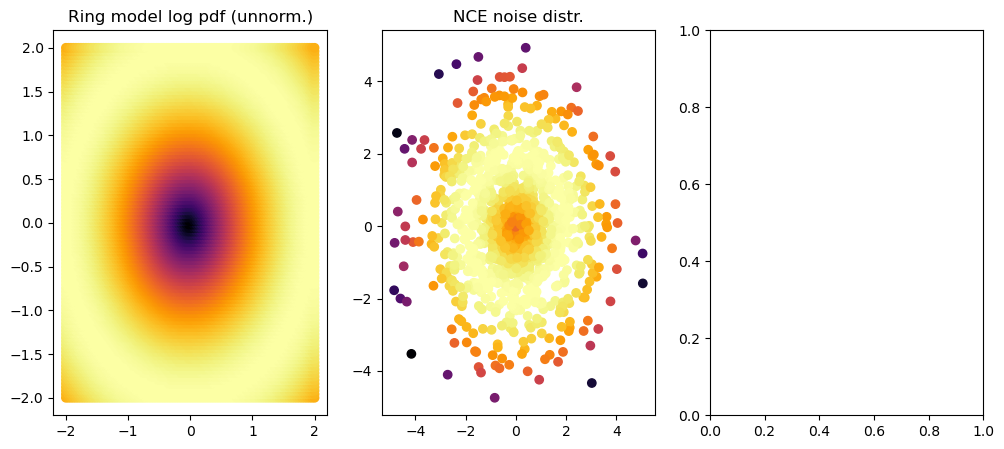

In [8]:
# 2D example
num_dims = 2
mu, precision = 2, 1
num_noise_samples = 1000
y = RingModelDataset(sample_size=num_noise_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Ring model pdf 
grid_size = 100
x_min, x_max = -2, 2
nx = np.linspace(x_min, x_max, grid_size)
X, Y = np.meshgrid(nx, nx)
x = torch.tensor(np.column_stack((X.reshape(-1), Y.reshape(-1))))

log_pdf = unnorm_ring_model_log_pdf(x, mu=mu, precision=precision).reshape(grid_size, grid_size)

ax[0].scatter(X, Y, c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

# NCE noise distr
mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)
p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
y_samples_nce = p_n.sample(torch.Size((num_noise_samples,)))
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

# CNCE noise distr
num_neg_samples = 10

cov_noise_cnce = np.eye(num_dims, dtype=np.float32) * get_cnce_epsilon(y, num_neg_samples, mu, np.log(precision))**2
p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
y_samples_cnce = p_n.sample(torch.Size((num_noise_samples,)), y)
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            
    
# How does training data look?
plt.show()



In [12]:
print(torch.exp(log_pdf).max())

tensor(8.2870, dtype=torch.float64)


## EXPERIMENTS

In [ ]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [26]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, z = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu, precision=precision, 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = torch.eye(num_dims) * get_cnce_epsilon(training_data.get_full_data(), J, mu, log_precision_init)**2
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

[1] loss: 0.657
[1] evaluation metric: 0.038
[2] loss: 0.276
[2] evaluation metric: 0.010
[3] loss: -0.649
[3] evaluation metric: 0.004
[4] loss: -0.781
[4] evaluation metric: 0.082
[5] loss: -2.478
[5] evaluation metric: 0.104
[6] loss: -3.012
[6] evaluation metric: 0.111
[7] loss: -2.958
[7] evaluation metric: 0.121
[8] loss: -3.293
[8] evaluation metric: 0.130
[9] loss: -3.606
[9] evaluation metric: 0.134
[10] loss: -3.400
[10] evaluation metric: 0.141
[11] loss: -3.596
[11] evaluation metric: 0.147
[12] loss: -3.764
[12] evaluation metric: 0.152
[13] loss: -3.464
[13] evaluation metric: 0.160
[14] loss: -4.081
[14] evaluation metric: 0.164
[15] loss: -4.271
[15] evaluation metric: 0.166
[16] loss: -4.138
[16] evaluation metric: 0.172
[17] loss: -4.285
[17] evaluation metric: 0.177
[18] loss: -4.435
[18] evaluation metric: 0.181
[19] loss: -4.672
[19] evaluation metric: 0.183
[20] loss: -4.532
[20] evaluation metric: 0.187
[21] loss: -4.377
[21] evaluation metric: 0.190
[22] loss: -

[38] loss: -5.984
[38] evaluation metric: 0.240
[39] loss: -6.207
[39] evaluation metric: 0.242
[40] loss: -6.298
[40] evaluation metric: 0.244
[41] loss: -6.338
[41] evaluation metric: 0.246
[42] loss: -6.212
[42] evaluation metric: 0.247
[43] loss: -6.509
[43] evaluation metric: 0.249
[44] loss: -6.763
[44] evaluation metric: 0.250
[45] loss: -6.575
[45] evaluation metric: 0.251
[46] loss: -6.946
[46] evaluation metric: 0.251
[47] loss: -7.097
[47] evaluation metric: 0.253
[48] loss: -7.111
[48] evaluation metric: 0.253
[49] loss: -7.158
[49] evaluation metric: 0.254
[50] loss: -7.319
[50] evaluation metric: 0.255
[51] loss: -7.394
[51] evaluation metric: 0.256
[52] loss: -7.726
[52] evaluation metric: 0.256
[53] loss: -7.537
[53] evaluation metric: 0.257
[54] loss: -7.574
[54] evaluation metric: 0.258
[55] loss: -7.721
[55] evaluation metric: 0.259
[56] loss: -7.934
[56] evaluation metric: 0.260
[57] loss: -8.006
[57] evaluation metric: 0.260
[58] loss: -7.927
[58] evaluation metric

[33] loss: -6.772
[33] evaluation metric: 1.245
[34] loss: -6.732
[34] evaluation metric: 1.249
[35] loss: -6.977
[35] evaluation metric: 1.251
[36] loss: -7.233
[36] evaluation metric: 1.254
[37] loss: -7.058
[37] evaluation metric: 1.258
[38] loss: -7.166
[38] evaluation metric: 1.260
[39] loss: -7.087
[39] evaluation metric: 1.263
[40] loss: -7.067
[40] evaluation metric: 1.266
[41] loss: -7.479
[41] evaluation metric: 1.268
[42] loss: -7.576
[42] evaluation metric: 1.270
[43] loss: -7.714
[43] evaluation metric: 1.271
[44] loss: -7.924
[44] evaluation metric: 1.273
[45] loss: -7.887
[45] evaluation metric: 1.276
[46] loss: -8.133
[46] evaluation metric: 1.277
[47] loss: -8.086
[47] evaluation metric: 1.279
[48] loss: -8.247
[48] evaluation metric: 1.281
[49] loss: -8.148
[49] evaluation metric: 1.282
[50] loss: -8.363
[50] evaluation metric: 1.284
[51] loss: -8.738
[51] evaluation metric: 1.285
[52] loss: -8.711
[52] evaluation metric: 1.286
[53] loss: -8.840
[53] evaluation metric

[33] loss: -8.254
[33] evaluation metric: 0.345
[34] loss: -8.268
[34] evaluation metric: 0.345
[35] loss: -8.137
[35] evaluation metric: 0.346
[36] loss: -8.345
[36] evaluation metric: 0.347
[37] loss: -8.503
[37] evaluation metric: 0.348
[38] loss: -8.781
[38] evaluation metric: 0.348
[39] loss: -8.730
[39] evaluation metric: 0.349
[40] loss: -8.608
[40] evaluation metric: 0.350
[41] loss: -8.822
[41] evaluation metric: 0.350
[42] loss: -8.941
[42] evaluation metric: 0.351
[43] loss: -8.988
[43] evaluation metric: 0.352
[44] loss: -9.172
[44] evaluation metric: 0.352
[45] loss: -9.318
[45] evaluation metric: 0.353
[46] loss: -9.438
[46] evaluation metric: 0.353
[47] loss: -9.445
[47] evaluation metric: 0.354
[48] loss: -9.638
[48] evaluation metric: 0.354
[49] loss: -9.584
[49] evaluation metric: 0.355
[50] loss: -9.685
[50] evaluation metric: 0.355
[51] loss: -9.879
[51] evaluation metric: 0.356
[52] loss: -10.086
[52] evaluation metric: 0.356
[53] loss: -10.071
[53] evaluation metr

[8] loss: -1.677
[8] evaluation metric: 0.097
[9] loss: -3.305
[9] evaluation metric: 0.103
[10] loss: -2.749
[10] evaluation metric: 0.114
[11] loss: -3.483
[11] evaluation metric: 0.120
[12] loss: -3.493
[12] evaluation metric: 0.127
[13] loss: -3.148
[13] evaluation metric: 0.136
[14] loss: -3.316
[14] evaluation metric: 0.146
[15] loss: -4.381
[15] evaluation metric: 0.148
[16] loss: -3.911
[16] evaluation metric: 0.151
[17] loss: -3.859
[17] evaluation metric: 0.155
[18] loss: -4.188
[18] evaluation metric: 0.157
[19] loss: -4.108
[19] evaluation metric: 0.163
[20] loss: -4.626
[20] evaluation metric: 0.164
[21] loss: -4.384
[21] evaluation metric: 0.166
[22] loss: -4.789
[22] evaluation metric: 0.168
[23] loss: -4.779
[23] evaluation metric: 0.169
[24] loss: -4.779
[24] evaluation metric: 0.171
[25] loss: -5.187
[25] evaluation metric: 0.172
[26] loss: -5.208
[26] evaluation metric: 0.174
[27] loss: -5.087
[27] evaluation metric: 0.177
[28] loss: -5.068
[28] evaluation metric: 0.

[83] loss: 0.573
[83] evaluation metric: 0.012
[84] loss: 0.610
[84] evaluation metric: 0.012
[85] loss: 0.545
[85] evaluation metric: 0.011
[86] loss: 0.596
[86] evaluation metric: 0.011
[87] loss: 0.545
[87] evaluation metric: 0.011
[88] loss: 0.618
[88] evaluation metric: 0.011
[89] loss: 0.477
[89] evaluation metric: 0.011
[90] loss: 0.637
[90] evaluation metric: 0.010
[91] loss: 0.637
[91] evaluation metric: 0.009
[92] loss: 0.616
[92] evaluation metric: 0.008
[93] loss: 0.616
[93] evaluation metric: 0.008
[94] loss: 0.631
[94] evaluation metric: 0.007
[95] loss: 0.674
[95] evaluation metric: 0.006
[96] loss: 0.679
[96] evaluation metric: 0.005
[97] loss: 0.730
[97] evaluation metric: 0.004
[98] loss: 0.633
[98] evaluation metric: 0.004
[99] loss: 0.509
[99] evaluation metric: 0.004
[100] loss: 0.504
[100] evaluation metric: 0.004
Finished training
Data saved
[1] loss: 1.556
[1] evaluation metric: 0.090
[2] loss: 1.708
[2] evaluation metric: 0.138
[3] loss: 1.044
[3] evaluation me

[2] loss: 2.182
[2] evaluation metric: 0.515
[3] loss: 1.505
[3] evaluation metric: 0.283
[4] loss: 1.395
[4] evaluation metric: 0.112
[5] loss: 1.583
[5] evaluation metric: 0.058
[6] loss: 0.857
[6] evaluation metric: 0.016
[7] loss: 1.039
[7] evaluation metric: 0.000
[8] loss: -0.837
[8] evaluation metric: 0.065
[9] loss: -1.721
[9] evaluation metric: 0.112
[10] loss: -2.074
[10] evaluation metric: 0.153
[11] loss: -2.952
[11] evaluation metric: 0.172
[12] loss: -3.812
[12] evaluation metric: 0.177
[13] loss: -3.411
[13] evaluation metric: 0.194
[14] loss: -3.597
[14] evaluation metric: 0.207
[15] loss: -3.387
[15] evaluation metric: 0.219
[16] loss: -3.582
[16] evaluation metric: 0.234
[17] loss: -4.333
[17] evaluation metric: 0.237
[18] loss: -4.209
[18] evaluation metric: 0.242
[19] loss: -4.269
[19] evaluation metric: 0.246
[20] loss: -4.507
[20] evaluation metric: 0.250
[21] loss: -4.914
[21] evaluation metric: 0.253
[22] loss: -4.644
[22] evaluation metric: 0.256
[23] loss: -4.

[28] loss: -4.868
[28] evaluation metric: 1.702
[29] loss: -5.104
[29] evaluation metric: 1.710
[30] loss: -4.988
[30] evaluation metric: 1.719
[31] loss: -5.670
[31] evaluation metric: 1.724
[32] loss: -5.612
[32] evaluation metric: 1.728
[33] loss: -5.640
[33] evaluation metric: 1.732
[34] loss: -5.821
[34] evaluation metric: 1.736
[35] loss: -6.106
[35] evaluation metric: 1.739
[36] loss: -5.755
[36] evaluation metric: 1.744
[37] loss: -5.781
[37] evaluation metric: 1.750
[38] loss: -6.520
[38] evaluation metric: 1.752
[39] loss: -6.284
[39] evaluation metric: 1.756
[40] loss: -6.427
[40] evaluation metric: 1.759
[41] loss: -6.177
[41] evaluation metric: 1.764
[42] loss: -6.772
[42] evaluation metric: 1.766
[43] loss: -6.590
[43] evaluation metric: 1.768
[44] loss: -6.987
[44] evaluation metric: 1.770
[45] loss: -7.026
[45] evaluation metric: 1.772
[46] loss: -6.847
[46] evaluation metric: 1.776
[47] loss: -7.266
[47] evaluation metric: 1.777
[48] loss: -6.976
[48] evaluation metric

[59] loss: -7.150
[59] evaluation metric: 1.198
[60] loss: -6.890
[60] evaluation metric: 1.201
[61] loss: -7.586
[61] evaluation metric: 1.202
[62] loss: -7.355
[62] evaluation metric: 1.203
[63] loss: -7.455
[63] evaluation metric: 1.205
[64] loss: -7.495
[64] evaluation metric: 1.207
[65] loss: -7.691
[65] evaluation metric: 1.208
[66] loss: -7.552
[66] evaluation metric: 1.210
[67] loss: -7.995
[67] evaluation metric: 1.212
[68] loss: -7.846
[68] evaluation metric: 1.213
[69] loss: -8.186
[69] evaluation metric: 1.214
[70] loss: -8.175
[70] evaluation metric: 1.216
[71] loss: -8.369
[71] evaluation metric: 1.217
[72] loss: -8.383
[72] evaluation metric: 1.218
[73] loss: -8.311
[73] evaluation metric: 1.220
[74] loss: -8.404
[74] evaluation metric: 1.221
[75] loss: -8.598
[75] evaluation metric: 1.223
[76] loss: -9.084
[76] evaluation metric: 1.224
[77] loss: -8.721
[77] evaluation metric: 1.225
[78] loss: -9.113
[78] evaluation metric: 1.226
[79] loss: -8.924
[79] evaluation metric

[48] loss: 0.439
[48] evaluation metric: 4.850
[49] loss: 0.476
[49] evaluation metric: 4.821
[50] loss: 0.466
[50] evaluation metric: 4.775
[51] loss: 0.467
[51] evaluation metric: 4.730
[52] loss: 0.527
[52] evaluation metric: 4.699
[53] loss: 0.530
[53] evaluation metric: 4.678
[54] loss: 0.510
[54] evaluation metric: 4.649
[55] loss: 0.499
[55] evaluation metric: 4.610
[56] loss: 0.513
[56] evaluation metric: 4.580
[57] loss: 0.538
[57] evaluation metric: 4.547
[58] loss: 0.582
[58] evaluation metric: 4.537
[59] loss: 0.460
[59] evaluation metric: 4.498
[60] loss: 0.511
[60] evaluation metric: 4.457
[61] loss: 0.541
[61] evaluation metric: 4.426
[62] loss: 0.540
[62] evaluation metric: 4.402
[63] loss: 0.483
[63] evaluation metric: 4.355
[64] loss: 0.443
[64] evaluation metric: 4.324
[65] loss: 0.473
[65] evaluation metric: 4.286
[66] loss: 0.472
[66] evaluation metric: 4.242
[67] loss: 0.506
[67] evaluation metric: 4.206
[68] loss: 0.469
[68] evaluation metric: 4.163
[69] loss: 0.

[37] loss: 0.480
[37] evaluation metric: 0.542
[38] loss: 0.602
[38] evaluation metric: 0.507
[39] loss: 0.488
[39] evaluation metric: 0.495
[40] loss: 0.604
[40] evaluation metric: 0.468
[41] loss: 0.629
[41] evaluation metric: 0.429
[42] loss: 0.566
[42] evaluation metric: 0.411
[43] loss: 0.557
[43] evaluation metric: 0.390
[44] loss: 0.527
[44] evaluation metric: 0.370
[45] loss: 0.456
[45] evaluation metric: 0.361
[46] loss: 0.525
[46] evaluation metric: 0.343
[47] loss: 0.558
[47] evaluation metric: 0.327
[48] loss: 0.504
[48] evaluation metric: 0.314
[49] loss: 0.516
[49] evaluation metric: 0.303
[50] loss: 0.522
[50] evaluation metric: 0.297
[51] loss: 0.523
[51] evaluation metric: 0.288
[52] loss: 0.537
[52] evaluation metric: 0.282
[53] loss: 0.530
[53] evaluation metric: 0.277
[54] loss: 0.442
[54] evaluation metric: 0.278
[55] loss: 0.481
[55] evaluation metric: 0.270
[56] loss: 0.575
[56] evaluation metric: 0.257
[57] loss: 0.485
[57] evaluation metric: 0.255
[58] loss: 0.

[47] loss: -7.871
[47] evaluation metric: 0.469
[48] loss: -7.998
[48] evaluation metric: 0.470
[49] loss: -8.151
[49] evaluation metric: 0.470
[50] loss: -8.065
[50] evaluation metric: 0.471
[51] loss: -8.306
[51] evaluation metric: 0.471
[52] loss: -8.242
[52] evaluation metric: 0.472
[53] loss: -8.383
[53] evaluation metric: 0.472
[54] loss: -8.612
[54] evaluation metric: 0.473
[55] loss: -8.818
[55] evaluation metric: 0.473
[56] loss: -8.894
[56] evaluation metric: 0.474
[57] loss: -8.915
[57] evaluation metric: 0.474
[58] loss: -9.140
[58] evaluation metric: 0.474
[59] loss: -9.300
[59] evaluation metric: 0.475
[60] loss: -9.286
[60] evaluation metric: 0.475
[61] loss: -9.296
[61] evaluation metric: 0.475
[62] loss: -9.380
[62] evaluation metric: 0.476
[63] loss: -9.777
[63] evaluation metric: 0.476
[64] loss: -9.659
[64] evaluation metric: 0.477
[65] loss: -9.792
[65] evaluation metric: 0.477
[66] loss: -9.945
[66] evaluation metric: 0.477
[67] loss: -9.745
[67] evaluation metric

[85] loss: -10.289
[85] evaluation metric: 0.331
[86] loss: -10.380
[86] evaluation metric: 0.331
[87] loss: -10.439
[87] evaluation metric: 0.332
[88] loss: -10.631
[88] evaluation metric: 0.332
[89] loss: -10.542
[89] evaluation metric: 0.332
[90] loss: -10.726
[90] evaluation metric: 0.332
[91] loss: -10.771
[91] evaluation metric: 0.332
[92] loss: -11.138
[92] evaluation metric: 0.333
[93] loss: -11.091
[93] evaluation metric: 0.333
[94] loss: -11.238
[94] evaluation metric: 0.333
[95] loss: -11.390
[95] evaluation metric: 0.333
[96] loss: -11.437
[96] evaluation metric: 0.333
[97] loss: -11.383
[97] evaluation metric: 0.334
[98] loss: -11.691
[98] evaluation metric: 0.334
[99] loss: -11.715
[99] evaluation metric: 0.334
[100] loss: -11.773
[100] evaluation metric: 0.334
Finished training
Data saved
[1] loss: 1.256
[1] evaluation metric: 1.669
[2] loss: 1.011
[2] evaluation metric: 1.388
[3] loss: 0.991
[3] evaluation metric: 1.155
[4] loss: 0.981
[4] evaluation metric: 0.960
[5] l

[28] loss: 0.393
[28] evaluation metric: 26.650
[29] loss: 0.389
[29] evaluation metric: 26.460
[30] loss: 0.436
[30] evaluation metric: 26.300
[31] loss: 0.425
[31] evaluation metric: 26.066
[32] loss: 0.388
[32] evaluation metric: 25.811
[33] loss: 0.480
[33] evaluation metric: 25.641
[34] loss: 0.425
[34] evaluation metric: 25.452
[35] loss: 0.442
[35] evaluation metric: 25.279
[36] loss: 0.407
[36] evaluation metric: 25.061
[37] loss: 0.409
[37] evaluation metric: 24.851
[38] loss: 0.395
[38] evaluation metric: 24.670
[39] loss: 0.406
[39] evaluation metric: 24.431
[40] loss: 0.387
[40] evaluation metric: 24.184
[41] loss: 0.395
[41] evaluation metric: 23.995
[42] loss: 0.427
[42] evaluation metric: 23.780
[43] loss: 0.391
[43] evaluation metric: 23.541
[44] loss: 0.348
[44] evaluation metric: 23.316
[45] loss: 0.383
[45] evaluation metric: 23.108
[46] loss: 0.416
[46] evaluation metric: 22.901
[47] loss: 0.366
[47] evaluation metric: 22.664
[48] loss: 0.412
[48] evaluation metric:

[75] loss: 0.426
[75] evaluation metric: 0.462
[76] loss: 0.337
[76] evaluation metric: 0.382
[77] loss: 0.400
[77] evaluation metric: 0.317
[78] loss: 0.362
[78] evaluation metric: 0.271
[79] loss: 0.355
[79] evaluation metric: 0.224
[80] loss: 0.374
[80] evaluation metric: 0.172
[81] loss: 0.371
[81] evaluation metric: 0.135
[82] loss: 0.418
[82] evaluation metric: 0.102
[83] loss: 0.382
[83] evaluation metric: 0.076
[84] loss: 0.340
[84] evaluation metric: 0.049
[85] loss: 0.352
[85] evaluation metric: 0.025
[86] loss: 0.328
[86] evaluation metric: 0.009
[87] loss: 0.307
[87] evaluation metric: 0.003
[88] loss: 0.331
[88] evaluation metric: 0.000
[89] loss: 0.389
[89] evaluation metric: 0.004
[90] loss: 0.330
[90] evaluation metric: 0.012
[91] loss: 0.361
[91] evaluation metric: 0.025
[92] loss: 0.396
[92] evaluation metric: 0.050
[93] loss: 0.370
[93] evaluation metric: 0.085
[94] loss: 0.331
[94] evaluation metric: 0.121
[95] loss: 0.394
[95] evaluation metric: 0.154
[96] loss: 0.

[69] loss: 0.695
[69] evaluation metric: 0.007
[70] loss: 0.728
[70] evaluation metric: 0.007
[71] loss: 0.704
[71] evaluation metric: 0.008
[72] loss: 0.635
[72] evaluation metric: 0.008
[73] loss: 0.716
[73] evaluation metric: 0.008
[74] loss: 0.669
[74] evaluation metric: 0.008
[75] loss: 0.777
[75] evaluation metric: 0.009
[76] loss: 0.710
[76] evaluation metric: 0.009
[77] loss: 0.720
[77] evaluation metric: 0.010
[78] loss: 0.716
[78] evaluation metric: 0.010
[79] loss: 0.698
[79] evaluation metric: 0.011
[80] loss: 0.656
[80] evaluation metric: 0.011
[81] loss: 0.697
[81] evaluation metric: 0.011
[82] loss: 0.697
[82] evaluation metric: 0.011
[83] loss: 0.712
[83] evaluation metric: 0.012
[84] loss: 0.673
[84] evaluation metric: 0.012
[85] loss: 0.728
[85] evaluation metric: 0.012
[86] loss: 0.678
[86] evaluation metric: 0.013
[87] loss: 0.738
[87] evaluation metric: 0.013
[88] loss: 0.715
[88] evaluation metric: 0.014
[89] loss: 0.739
[89] evaluation metric: 0.014
[90] loss: 0.

[39] evaluation metric: 29.397
[40] loss: 0.486
[40] evaluation metric: 29.215
[41] loss: 0.485
[41] evaluation metric: 29.033
[42] loss: 0.536
[42] evaluation metric: 28.887
[43] loss: 0.482
[43] evaluation metric: 28.710
[44] loss: 0.447
[44] evaluation metric: 28.491
[45] loss: 0.471
[45] evaluation metric: 28.312
[46] loss: 0.466
[46] evaluation metric: 28.152
[47] loss: 0.508
[47] evaluation metric: 28.000
[48] loss: 0.478
[48] evaluation metric: 27.795
[49] loss: 0.473
[49] evaluation metric: 27.597
[50] loss: 0.529
[50] evaluation metric: 27.447
[51] loss: 0.486
[51] evaluation metric: 27.236
[52] loss: 0.513
[52] evaluation metric: 27.068
[53] loss: 0.470
[53] evaluation metric: 26.901
[54] loss: 0.508
[54] evaluation metric: 26.748
[55] loss: 0.445
[55] evaluation metric: 26.557
[56] loss: 0.484
[56] evaluation metric: 26.371
[57] loss: 0.474
[57] evaluation metric: 26.170
[58] loss: 0.512
[58] evaluation metric: 26.013
[59] loss: 0.429
[59] evaluation metric: 25.741
[60] loss

[38] loss: 0.554
[38] evaluation metric: 0.183
[39] loss: 0.586
[39] evaluation metric: 0.182
[40] loss: 0.567
[40] evaluation metric: 0.183
[41] loss: 0.570
[41] evaluation metric: 0.184
[42] loss: 0.517
[42] evaluation metric: 0.184
[43] loss: 0.494
[43] evaluation metric: 0.181
[44] loss: 0.498
[44] evaluation metric: 0.177
[45] loss: 0.532
[45] evaluation metric: 0.178
[46] loss: 0.559
[46] evaluation metric: 0.178
[47] loss: 0.537
[47] evaluation metric: 0.175
[48] loss: 0.480
[48] evaluation metric: 0.171
[49] loss: 0.508
[49] evaluation metric: 0.167
[50] loss: 0.539
[50] evaluation metric: 0.168
[51] loss: 0.579
[51] evaluation metric: 0.169
[52] loss: 0.554
[52] evaluation metric: 0.169
[53] loss: 0.552
[53] evaluation metric: 0.168
[54] loss: 0.469
[54] evaluation metric: 0.163
[55] loss: 0.584
[55] evaluation metric: 0.166
[56] loss: 0.614
[56] evaluation metric: 0.170
[57] loss: 0.567
[57] evaluation metric: 0.171
[58] loss: 0.560
[58] evaluation metric: 0.173
[59] loss: 0.

[34] loss: 0.243
[34] evaluation metric: 36.785
[35] loss: 0.240
[35] evaluation metric: 36.421
[36] loss: 0.254
[36] evaluation metric: 36.128
[37] loss: 0.281
[37] evaluation metric: 35.747
[38] loss: 0.237
[38] evaluation metric: 35.417
[39] loss: 0.264
[39] evaluation metric: 35.086
[40] loss: 0.196
[40] evaluation metric: 34.745
[41] loss: 0.276
[41] evaluation metric: 34.413
[42] loss: 0.268
[42] evaluation metric: 34.125
[43] loss: 0.236
[43] evaluation metric: 33.753
[44] loss: 0.241
[44] evaluation metric: 33.361
[45] loss: 0.221
[45] evaluation metric: 33.026
[46] loss: 0.239
[46] evaluation metric: 32.643
[47] loss: 0.301
[47] evaluation metric: 32.305
[48] loss: 0.296
[48] evaluation metric: 31.943
[49] loss: 0.258
[49] evaluation metric: 31.558
[50] loss: 0.248
[50] evaluation metric: 31.176
[51] loss: 0.279
[51] evaluation metric: 30.799
[52] loss: 0.297
[52] evaluation metric: 30.463
[53] loss: 0.225
[53] evaluation metric: 30.116
[54] loss: 0.266
[54] evaluation metric:

[32] loss: 0.700
[32] evaluation metric: 0.330
[33] loss: 0.658
[33] evaluation metric: 0.313
[34] loss: 0.711
[34] evaluation metric: 0.290
[35] loss: 0.725
[35] evaluation metric: 0.269
[36] loss: 0.714
[36] evaluation metric: 0.250
[37] loss: 0.692
[37] evaluation metric: 0.234
[38] loss: 0.690
[38] evaluation metric: 0.220
[39] loss: 0.712
[39] evaluation metric: 0.206
[40] loss: 0.702
[40] evaluation metric: 0.192
[41] loss: 0.714
[41] evaluation metric: 0.177
[42] loss: 0.722
[42] evaluation metric: 0.165
[43] loss: 0.673
[43] evaluation metric: 0.156
[44] loss: 0.707
[44] evaluation metric: 0.144
[45] loss: 0.580
[45] evaluation metric: 0.141
[46] loss: 0.719
[46] evaluation metric: 0.131
[47] loss: 0.679
[47] evaluation metric: 0.123
[48] loss: 0.652
[48] evaluation metric: 0.117
[49] loss: 0.723
[49] evaluation metric: 0.106
[50] loss: 0.688
[50] evaluation metric: 0.100
[51] loss: 0.705
[51] evaluation metric: 0.093
[52] loss: 0.642
[52] evaluation metric: 0.089
[53] loss: 0.

[86] evaluation metric: 0.092
[87] loss: 0.517
[87] evaluation metric: 0.091
[88] loss: 0.555
[88] evaluation metric: 0.090
[89] loss: 0.506
[89] evaluation metric: 0.089
[90] loss: 0.524
[90] evaluation metric: 0.090
[91] loss: 0.544
[91] evaluation metric: 0.090
[92] loss: 0.496
[92] evaluation metric: 0.090
[93] loss: 0.516
[93] evaluation metric: 0.090
[94] loss: 0.497
[94] evaluation metric: 0.090
[95] loss: 0.568
[95] evaluation metric: 0.086
[96] loss: 0.496
[96] evaluation metric: 0.085
[97] loss: 0.527
[97] evaluation metric: 0.085
[98] loss: 0.564
[98] evaluation metric: 0.082
[99] loss: 0.482
[99] evaluation metric: 0.083
[100] loss: 0.511
[100] evaluation metric: 0.082
Finished training
Data saved
[1] loss: 3.474
[1] evaluation metric: 0.211
[2] loss: 3.121
[2] evaluation metric: 0.330
[3] loss: 2.924
[3] evaluation metric: 0.433
[4] loss: 2.396
[4] evaluation metric: 0.552
[5] loss: 2.397
[5] evaluation metric: 0.647
[6] loss: 1.887
[6] evaluation metric: 0.754
[7] loss: 1

[92] loss: 0.574
[92] evaluation metric: 0.094
[93] loss: 0.547
[93] evaluation metric: 0.094
[94] loss: 0.518
[94] evaluation metric: 0.092
[95] loss: 0.509
[95] evaluation metric: 0.090
[96] loss: 0.528
[96] evaluation metric: 0.089
[97] loss: 0.585
[97] evaluation metric: 0.089
[98] loss: 0.554
[98] evaluation metric: 0.090
[99] loss: 0.570
[99] evaluation metric: 0.090
[100] loss: 0.511
[100] evaluation metric: 0.088
Finished training
Data saved
[1] loss: 2.800
[1] evaluation metric: 0.099
[2] loss: 2.409
[2] evaluation metric: 0.159
[3] loss: 2.383
[3] evaluation metric: 0.214
[4] loss: 2.016
[4] evaluation metric: 0.265
[5] loss: 1.465
[5] evaluation metric: 0.313
[6] loss: 0.591
[6] evaluation metric: 0.354
[7] loss: 0.170
[7] evaluation metric: 0.381
[8] loss: 0.178
[8] evaluation metric: 0.405
[9] loss: 0.008
[9] evaluation metric: 0.422
[10] loss: -0.361
[10] evaluation metric: 0.437
[11] loss: -0.383
[11] evaluation metric: 0.449
[12] loss: -0.390
[12] evaluation metric: 0.4

[79] loss: 0.579
[79] evaluation metric: 0.073
[80] loss: 0.598
[80] evaluation metric: 0.073
[81] loss: 0.518
[81] evaluation metric: 0.072
[82] loss: 0.546
[82] evaluation metric: 0.072
[83] loss: 0.603
[83] evaluation metric: 0.072
[84] loss: 0.585
[84] evaluation metric: 0.072
[85] loss: 0.607
[85] evaluation metric: 0.073
[86] loss: 0.595
[86] evaluation metric: 0.073
[87] loss: 0.585
[87] evaluation metric: 0.073
[88] loss: 0.560
[88] evaluation metric: 0.073
[89] loss: 0.562
[89] evaluation metric: 0.073
[90] loss: 0.548
[90] evaluation metric: 0.072
[91] loss: 0.560
[91] evaluation metric: 0.072
[92] loss: 0.597
[92] evaluation metric: 0.072
[93] loss: 0.588
[93] evaluation metric: 0.072
[94] loss: 0.605
[94] evaluation metric: 0.073
[95] loss: 0.567
[95] evaluation metric: 0.073
[96] loss: 0.539
[96] evaluation metric: 0.072
[97] loss: 0.574
[97] evaluation metric: 0.072
[98] loss: 0.604
[98] evaluation metric: 0.073
[99] loss: 0.578
[99] evaluation metric: 0.073
[100] loss: 0

[81] loss: 0.440
[81] evaluation metric: 0.438
[82] loss: 0.490
[82] evaluation metric: 0.441
[83] loss: 0.527
[83] evaluation metric: 0.443
[84] loss: 0.485
[84] evaluation metric: 0.449
[85] loss: 0.513
[85] evaluation metric: 0.453
[86] loss: 0.478
[86] evaluation metric: 0.460
[87] loss: 0.500
[87] evaluation metric: 0.464
[88] loss: 0.482
[88] evaluation metric: 0.471
[89] loss: 0.506
[89] evaluation metric: 0.474
[90] loss: 0.490
[90] evaluation metric: 0.481
[91] loss: 0.455
[91] evaluation metric: 0.492
[92] loss: 0.491
[92] evaluation metric: 0.498
[93] loss: 0.472
[93] evaluation metric: 0.507
[94] loss: 0.453
[94] evaluation metric: 0.518
[95] loss: 0.478
[95] evaluation metric: 0.524
[96] loss: 0.469
[96] evaluation metric: 0.531
[97] loss: 0.451
[97] evaluation metric: 0.544
[98] loss: 0.486
[98] evaluation metric: 0.551
[99] loss: 0.500
[99] evaluation metric: 0.553
[100] loss: 0.524
[100] evaluation metric: 0.554
Finished training
Data saved
[1] loss: 2.676
[1] evaluatio

[65] loss: 0.546
[65] evaluation metric: 0.100
[66] loss: 0.530
[66] evaluation metric: 0.099
[67] loss: 0.553
[67] evaluation metric: 0.099
Training converged
Finished training
Data saved
[1] loss: 4.949
[1] evaluation metric: 18.334
[2] loss: 4.968
[2] evaluation metric: 17.263
[3] loss: 7.786
[3] evaluation metric: 1.986
[4] loss: 11.771
[4] evaluation metric: 0.041
[5] loss: 3.852
[5] evaluation metric: 0.066
[6] loss: 3.841
[6] evaluation metric: 0.100
[7] loss: 3.463
[7] evaluation metric: 0.125
[8] loss: 3.521
[8] evaluation metric: 0.165
[9] loss: 3.393
[9] evaluation metric: 0.196
[10] loss: 2.885
[10] evaluation metric: 0.244
[11] loss: 2.545
[11] evaluation metric: 0.297
[12] loss: 1.946
[12] evaluation metric: 0.348
[13] loss: 1.756
[13] evaluation metric: 0.398
[14] loss: 0.981
[14] evaluation metric: 0.425
[15] loss: 1.034
[15] evaluation metric: 0.448
[16] loss: 0.423
[16] evaluation metric: 0.461
[17] loss: 0.250
[17] evaluation metric: 0.472
[18] loss: 0.294
[18] evalu

[98] loss: 0.428
[98] evaluation metric: 0.108
[99] loss: 0.408
[99] evaluation metric: 0.107
[100] loss: 0.417
[100] evaluation metric: 0.106
Finished training
Data saved
[1] loss: 4.235
[1] evaluation metric: 1.039
[2] loss: 3.991
[2] evaluation metric: 0.724
[3] loss: 3.857
[3] evaluation metric: 0.511
[4] loss: 3.782
[4] evaluation metric: 0.275
[5] loss: 3.787
[5] evaluation metric: 0.138
[6] loss: 3.905
[6] evaluation metric: 0.033
[7] loss: 3.537
[7] evaluation metric: 0.007
[8] loss: 3.119
[8] evaluation metric: 0.002
[9] loss: 2.774
[9] evaluation metric: 0.020
[10] loss: 2.673
[10] evaluation metric: 0.055
[11] loss: 2.652
[11] evaluation metric: 0.108
[12] loss: 2.032
[12] evaluation metric: 0.164
[13] loss: 1.630
[13] evaluation metric: 0.223
[14] loss: 1.484
[14] evaluation metric: 0.275
[15] loss: 1.493
[15] evaluation metric: 0.320
[16] loss: 1.256
[16] evaluation metric: 0.377
[17] loss: 0.878
[17] evaluation metric: 0.411
[18] loss: 0.730
[18] evaluation metric: 0.439


[8] loss: 4.655
[8] evaluation metric: 10.408
[9] loss: 4.516
[9] evaluation metric: 12.055
[10] loss: 4.605
[10] evaluation metric: 13.401
[11] loss: 4.570
[11] evaluation metric: 15.007
[12] loss: 4.590
[12] evaluation metric: 16.522
[13] loss: 4.585
[13] evaluation metric: 17.953
[14] loss: 4.548
[14] evaluation metric: 19.505
[15] loss: 4.523
[15] evaluation metric: 21.613
[16] loss: 4.411
[16] evaluation metric: 23.531
[17] loss: 4.465
[17] evaluation metric: 25.585
[18] loss: 4.485
[18] evaluation metric: 27.398
[19] loss: 4.562
[19] evaluation metric: 29.199
[20] loss: 4.282
[20] evaluation metric: 31.619
[21] loss: 4.366
[21] evaluation metric: 33.543
[22] loss: 4.141
[22] evaluation metric: 35.667
[23] loss: 4.238
[23] evaluation metric: 37.415
[24] loss: 4.309
[24] evaluation metric: 39.295
[25] loss: 4.217
[25] evaluation metric: 41.579
[26] loss: 4.189
[26] evaluation metric: 43.294
[27] loss: 3.923
[27] evaluation metric: 45.715
[28] loss: 3.847
[28] evaluation metric: 47.

[14] loss: -0.914
[14] evaluation metric: 0.187
[15] loss: -0.885
[15] evaluation metric: 0.187
[16] loss: -1.130
[16] evaluation metric: 0.187
[17] loss: -1.173
[17] evaluation metric: 0.187
[18] loss: -1.238
[18] evaluation metric: 0.187
[19] loss: -1.436
[19] evaluation metric: 0.188
[20] loss: -1.541
[20] evaluation metric: 0.188
[21] loss: -1.571
[21] evaluation metric: 0.188
[22] loss: -1.705
[22] evaluation metric: 0.188
[23] loss: -1.687
[23] evaluation metric: 0.188
[24] loss: -1.847
[24] evaluation metric: 0.188
[25] loss: -2.000
[25] evaluation metric: 0.189
[26] loss: -2.063
[26] evaluation metric: 0.189
[27] loss: -2.248
[27] evaluation metric: 0.189
[28] loss: -2.252
[28] evaluation metric: 0.189
[29] loss: -2.327
[29] evaluation metric: 0.189
[30] loss: -2.493
[30] evaluation metric: 0.189
[31] loss: -2.567
[31] evaluation metric: 0.190
[32] loss: -2.619
[32] evaluation metric: 0.190
[33] loss: -2.766
[33] evaluation metric: 0.190
[34] loss: -2.858
[34] evaluation metric

[52] loss: -24.244
[52] evaluation metric: 0.223
[53] loss: -24.778
[53] evaluation metric: 0.223
[54] loss: -24.975
[54] evaluation metric: 0.224
[55] loss: -25.531
[55] evaluation metric: 0.225
[56] loss: -25.910
[56] evaluation metric: 0.225
[57] loss: -26.332
[57] evaluation metric: 0.226
[58] loss: -26.909
[58] evaluation metric: 0.226
[59] loss: -27.139
[59] evaluation metric: 0.227
[60] loss: -27.219
[60] evaluation metric: 0.227
[61] loss: -27.666
[61] evaluation metric: 0.228
[62] loss: -27.891
[62] evaluation metric: 0.228
[63] loss: -28.711
[63] evaluation metric: 0.229
[64] loss: -29.162
[64] evaluation metric: 0.229
[65] loss: -29.139
[65] evaluation metric: 0.230
[66] loss: -29.704
[66] evaluation metric: 0.230
[67] loss: -30.220
[67] evaluation metric: 0.230
[68] loss: -30.698
[68] evaluation metric: 0.231
[69] loss: -31.278
[69] evaluation metric: 0.231
[70] loss: -31.519
[70] evaluation metric: 0.231
[71] loss: -31.787
[71] evaluation metric: 0.232
[72] loss: -32.277
[

[90] loss: -36.583
[90] evaluation metric: 9.358
[91] loss: -36.991
[91] evaluation metric: 9.359
[92] loss: -37.034
[92] evaluation metric: 9.360
[93] loss: -37.748
[93] evaluation metric: 9.361
[94] loss: -37.993
[94] evaluation metric: 9.361
[95] loss: -38.520
[95] evaluation metric: 9.362
[96] loss: -39.041
[96] evaluation metric: 9.363
[97] loss: -39.117
[97] evaluation metric: 9.363
[98] loss: -39.608
[98] evaluation metric: 9.364
[99] loss: -40.015
[99] evaluation metric: 9.365
[100] loss: -40.497
[100] evaluation metric: 9.365
Finished training
Data saved
[1] loss: 0.792
[1] evaluation metric: 1.381
[2] loss: 0.882
[2] evaluation metric: 1.340
[3] loss: 0.809
[3] evaluation metric: 1.283
[4] loss: 0.873
[4] evaluation metric: 1.230
[5] loss: 0.899
[5] evaluation metric: 1.227
[6] loss: 0.788
[6] evaluation metric: 1.195
[7] loss: 0.938
[7] evaluation metric: 1.197
[8] loss: 0.877
[8] evaluation metric: 1.175
[9] loss: 0.678
[9] evaluation metric: 1.097
[10] loss: 0.772
[10] eva

[100] loss: -42.608
[100] evaluation metric: 6.737
Finished training
Data saved
[1] loss: 1.124
[1] evaluation metric: 11.414
[2] loss: 1.077
[2] evaluation metric: 9.349
[3] loss: 0.800
[3] evaluation metric: 8.696
[4] loss: 1.158
[4] evaluation metric: 7.080
[5] loss: 0.989
[5] evaluation metric: 6.066
[6] loss: 0.834
[6] evaluation metric: 5.567
[7] loss: 0.674
[7] evaluation metric: 5.376
[8] loss: 0.928
[8] evaluation metric: 4.799
[9] loss: 0.846
[9] evaluation metric: 4.155
[10] loss: 1.161
[10] evaluation metric: 3.213
[11] loss: 0.990
[11] evaluation metric: 2.968
[12] loss: 0.646
[12] evaluation metric: 2.994
[13] loss: 0.808
[13] evaluation metric: 2.696
[14] loss: 0.812
[14] evaluation metric: 2.520
[15] loss: 0.918
[15] evaluation metric: 2.293
[16] loss: 0.880
[16] evaluation metric: 1.961
[17] loss: 0.984
[17] evaluation metric: 1.651
[18] loss: 1.020
[18] evaluation metric: 1.361
[19] loss: 0.667
[19] evaluation metric: 1.400
[20] loss: 0.549
[20] evaluation metric: 1.4

[82] loss: -41.765
[82] evaluation metric: 0.399
[83] loss: -42.164
[83] evaluation metric: 0.399
[84] loss: -42.678
[84] evaluation metric: 0.399
[85] loss: -42.591
[85] evaluation metric: 0.399
[86] loss: -43.074
[86] evaluation metric: 0.400
[87] loss: -43.657
[87] evaluation metric: 0.400
[88] loss: -43.973
[88] evaluation metric: 0.400
[89] loss: -44.556
[89] evaluation metric: 0.400
[90] loss: -44.876
[90] evaluation metric: 0.400
[91] loss: -44.998
[91] evaluation metric: 0.400
[92] loss: -45.879
[92] evaluation metric: 0.400
[93] loss: -45.861
[93] evaluation metric: 0.401
[94] loss: -46.404
[94] evaluation metric: 0.401
[95] loss: -46.675
[95] evaluation metric: 0.401
[96] loss: -47.316
[96] evaluation metric: 0.401
[97] loss: -48.079
[97] evaluation metric: 0.401
[98] loss: -48.147
[98] evaluation metric: 0.401
[99] loss: -48.422
[99] evaluation metric: 0.401
[100] loss: -48.611
[100] evaluation metric: 0.402
Finished training
Data saved
[1] loss: 1.033
[1] evaluation metric:

[65] loss: -28.274
[65] evaluation metric: 1.709
[66] loss: -28.995
[66] evaluation metric: 1.710
[67] loss: -29.573
[67] evaluation metric: 1.711
[68] loss: -29.726
[68] evaluation metric: 1.712
[69] loss: -30.252
[69] evaluation metric: 1.713
[70] loss: -30.510
[70] evaluation metric: 1.714
[71] loss: -30.763
[71] evaluation metric: 1.715
[72] loss: -31.250
[72] evaluation metric: 1.716
[73] loss: -31.636
[73] evaluation metric: 1.717
[74] loss: -31.967
[74] evaluation metric: 1.718
[75] loss: -32.730
[75] evaluation metric: 1.719
[76] loss: -33.301
[76] evaluation metric: 1.719
[77] loss: -33.571
[77] evaluation metric: 1.720
[78] loss: -33.765
[78] evaluation metric: 1.721
[79] loss: -34.417
[79] evaluation metric: 1.721
[80] loss: -34.608
[80] evaluation metric: 1.722
[81] loss: -34.682
[81] evaluation metric: 1.723
[82] loss: -35.366
[82] evaluation metric: 1.724
[83] loss: -35.919
[83] evaluation metric: 1.724
[84] loss: -36.333
[84] evaluation metric: 1.725
[85] loss: -36.564
[

[80] loss: -41.540
[80] evaluation metric: 63.285
[81] loss: -41.869
[81] evaluation metric: 63.287
[82] loss: -42.055
[82] evaluation metric: 63.289
[83] loss: -42.683
[83] evaluation metric: 63.291
[84] loss: -42.831
[84] evaluation metric: 63.292
[85] loss: -43.750
[85] evaluation metric: 63.294
[86] loss: -43.928
[86] evaluation metric: 63.295
[87] loss: -44.679
[87] evaluation metric: 63.297
[88] loss: -44.870
[88] evaluation metric: 63.298
[89] loss: -45.025
[89] evaluation metric: 63.300
[90] loss: -45.787
[90] evaluation metric: 63.301
[91] loss: -45.877
[91] evaluation metric: 63.302
[92] loss: -46.553
[92] evaluation metric: 63.304
[93] loss: -46.636
[93] evaluation metric: 63.305
[94] loss: -47.290
[94] evaluation metric: 63.306
[95] loss: -47.753
[95] evaluation metric: 63.308
[96] loss: -47.792
[96] evaluation metric: 63.309
[97] loss: -48.516
[97] evaluation metric: 63.310
[98] loss: -48.426
[98] evaluation metric: 63.312
[99] loss: -49.069
[99] evaluation metric: 63.313


[95] loss: -42.816
[95] evaluation metric: 0.352
[96] loss: -42.904
[96] evaluation metric: 0.353
[97] loss: -43.307
[97] evaluation metric: 0.353
[98] loss: -43.764
[98] evaluation metric: 0.353
[99] loss: -44.197
[99] evaluation metric: 0.353
[100] loss: -44.583
[100] evaluation metric: 0.353
Finished training
Data saved
[1] loss: 1.185
[1] evaluation metric: 0.042
[2] loss: 1.052
[2] evaluation metric: 0.042
[3] loss: 1.228
[3] evaluation metric: 0.039
[4] loss: 1.141
[4] evaluation metric: 0.037
[5] loss: 1.189
[5] evaluation metric: 0.035
[6] loss: 1.100
[6] evaluation metric: 0.036
[7] loss: 1.185
[7] evaluation metric: 0.034
[8] loss: 1.111
[8] evaluation metric: 0.033
[9] loss: 1.061
[9] evaluation metric: 0.034
[10] loss: 1.222
[10] evaluation metric: 0.032
[11] loss: 1.318
[11] evaluation metric: 0.027
[12] loss: 1.101
[12] evaluation metric: 0.028
[13] loss: 1.250
[13] evaluation metric: 0.025
[14] loss: 1.292
[14] evaluation metric: 0.022
[15] loss: 1.105
[15] evaluation me

[3] loss: 0.906
[3] evaluation metric: 1.184
[4] loss: 0.699
[4] evaluation metric: 1.232
[5] loss: 0.580
[5] evaluation metric: 1.224
[6] loss: 0.741
[6] evaluation metric: 1.241
[7] loss: 0.708
[7] evaluation metric: 1.250
[8] loss: 0.763
[8] evaluation metric: 1.272
[9] loss: 0.934
[9] evaluation metric: 1.375
[10] loss: 0.768
[10] evaluation metric: 1.400
[11] loss: 0.888
[11] evaluation metric: 1.455
[12] loss: 0.885
[12] evaluation metric: 1.507
[13] loss: 0.670
[13] evaluation metric: 1.553
[14] loss: 0.722
[14] evaluation metric: 1.588
[15] loss: 0.822
[15] evaluation metric: 1.597
[16] loss: 0.881
[16] evaluation metric: 1.673
[17] loss: 0.542
[17] evaluation metric: 1.607
[18] loss: 0.704
[18] evaluation metric: 1.528
[19] loss: 0.782
[19] evaluation metric: 1.507
[20] loss: 0.667
[20] evaluation metric: 1.441
[21] loss: 0.710
[21] evaluation metric: 1.431
[22] loss: 0.882
[22] evaluation metric: 1.551
[23] loss: 0.835
[23] evaluation metric: 1.577
[24] loss: 0.670
[24] evalu

[92] loss: -42.228
[92] evaluation metric: 0.200
[93] loss: -42.843
[93] evaluation metric: 0.200
[94] loss: -43.410
[94] evaluation metric: 0.200
[95] loss: -43.575
[95] evaluation metric: 0.200
[96] loss: -43.943
[96] evaluation metric: 0.200
[97] loss: -44.113
[97] evaluation metric: 0.200
[98] loss: -44.973
[98] evaluation metric: 0.200
[99] loss: -45.055
[99] evaluation metric: 0.200
[100] loss: -45.765
[100] evaluation metric: 0.200
Finished training
Data saved
[1] loss: 1.516
[1] evaluation metric: 0.672
[2] loss: 1.344
[2] evaluation metric: 0.567
[3] loss: 1.652
[3] evaluation metric: 0.442
[4] loss: 1.450
[4] evaluation metric: 0.352
[5] loss: 1.461
[5] evaluation metric: 0.285
[6] loss: 1.558
[6] evaluation metric: 0.225
[7] loss: 1.544
[7] evaluation metric: 0.169
[8] loss: 1.266
[8] evaluation metric: 0.147
[9] loss: 1.228
[9] evaluation metric: 0.127
[10] loss: 1.336
[10] evaluation metric: 0.108
[11] loss: 1.339
[11] evaluation metric: 0.089
[12] loss: 1.190
[12] evaluat

[68] loss: -29.739
[68] evaluation metric: 0.379
[69] loss: -30.143
[69] evaluation metric: 0.379
[70] loss: -30.761
[70] evaluation metric: 0.380
[71] loss: -30.785
[71] evaluation metric: 0.380
[72] loss: -31.313
[72] evaluation metric: 0.380
[73] loss: -31.514
[73] evaluation metric: 0.380
[74] loss: -31.957
[74] evaluation metric: 0.381
[75] loss: -32.454
[75] evaluation metric: 0.381
[76] loss: -33.218
[76] evaluation metric: 0.381
[77] loss: -33.311
[77] evaluation metric: 0.381
[78] loss: -33.708
[78] evaluation metric: 0.381
[79] loss: -34.133
[79] evaluation metric: 0.382
[80] loss: -34.209
[80] evaluation metric: 0.382
[81] loss: -34.974
[81] evaluation metric: 0.382
[82] loss: -35.146
[82] evaluation metric: 0.382
[83] loss: -35.750
[83] evaluation metric: 0.382
[84] loss: -35.970
[84] evaluation metric: 0.382
[85] loss: -36.535
[85] evaluation metric: 0.383
[86] loss: -37.090
[86] evaluation metric: 0.383
[87] loss: -37.513
[87] evaluation metric: 0.383
[88] loss: -37.726
[

[74] loss: -26.558
[74] evaluation metric: 4.340
[75] loss: -26.795
[75] evaluation metric: 4.341
[76] loss: -27.540
[76] evaluation metric: 4.342
[77] loss: -27.748
[77] evaluation metric: 4.343
[78] loss: -28.180
[78] evaluation metric: 4.344
[79] loss: -28.542
[79] evaluation metric: 4.345
[80] loss: -28.958
[80] evaluation metric: 4.346
[81] loss: -29.440
[81] evaluation metric: 4.347
[82] loss: -29.828
[82] evaluation metric: 4.348
[83] loss: -30.274
[83] evaluation metric: 4.349
[84] loss: -30.459
[84] evaluation metric: 4.350
[85] loss: -31.087
[85] evaluation metric: 4.351
[86] loss: -31.148
[86] evaluation metric: 4.352
[87] loss: -31.594
[87] evaluation metric: 4.353
[88] loss: -32.426
[88] evaluation metric: 4.354
[89] loss: -32.638
[89] evaluation metric: 4.354
[90] loss: -33.075
[90] evaluation metric: 4.355
[91] loss: -33.440
[91] evaluation metric: 4.356
[92] loss: -33.876
[92] evaluation metric: 4.357
[93] loss: -34.300
[93] evaluation metric: 4.357
[94] loss: -34.842
[

[62] loss: -24.047
[62] evaluation metric: 0.446
[63] loss: -24.415
[63] evaluation metric: 0.447
[64] loss: -24.927
[64] evaluation metric: 0.447
[65] loss: -25.307
[65] evaluation metric: 0.447
[66] loss: -25.290
[66] evaluation metric: 0.448
[67] loss: -26.031
[67] evaluation metric: 0.448
[68] loss: -26.392
[68] evaluation metric: 0.448
[69] loss: -26.562
[69] evaluation metric: 0.449
[70] loss: -27.045
[70] evaluation metric: 0.449
[71] loss: -27.920
[71] evaluation metric: 0.449
[72] loss: -28.126
[72] evaluation metric: 0.449
[73] loss: -28.280
[73] evaluation metric: 0.450
[74] loss: -28.650
[74] evaluation metric: 0.450
[75] loss: -29.174
[75] evaluation metric: 0.450
[76] loss: -29.594
[76] evaluation metric: 0.450
[77] loss: -29.880
[77] evaluation metric: 0.451
[78] loss: -30.600
[78] evaluation metric: 0.451
[79] loss: -30.600
[79] evaluation metric: 0.451
[80] loss: -31.036
[80] evaluation metric: 0.451
[81] loss: -31.599
[81] evaluation metric: 0.452
[82] loss: -31.708
[

[72] loss: -31.694
[72] evaluation metric: 12.739
[73] loss: -31.874
[73] evaluation metric: 12.740
[74] loss: -32.501
[74] evaluation metric: 12.742
[75] loss: -32.900
[75] evaluation metric: 12.743
[76] loss: -33.396
[76] evaluation metric: 12.744
[77] loss: -33.864
[77] evaluation metric: 12.745
[78] loss: -34.177
[78] evaluation metric: 12.746
[79] loss: -34.520
[79] evaluation metric: 12.747
[80] loss: -34.842
[80] evaluation metric: 12.748
[81] loss: -35.219
[81] evaluation metric: 12.749
[82] loss: -35.767
[82] evaluation metric: 12.750
[83] loss: -35.937
[83] evaluation metric: 12.752
[84] loss: -36.318
[84] evaluation metric: 12.753
[85] loss: -36.810
[85] evaluation metric: 12.754
[86] loss: -37.131
[86] evaluation metric: 12.755
[87] loss: -37.557
[87] evaluation metric: 12.756
[88] loss: -38.136
[88] evaluation metric: 12.757
[89] loss: -38.549
[89] evaluation metric: 12.758
[90] loss: -39.099
[90] evaluation metric: 12.758
[91] loss: -39.197
[91] evaluation metric: 12.759


[56] loss: -22.915
[56] evaluation metric: 38.227
[57] loss: -23.334
[57] evaluation metric: 38.230
[58] loss: -23.658
[58] evaluation metric: 38.233
[59] loss: -23.989
[59] evaluation metric: 38.235
[60] loss: -24.252
[60] evaluation metric: 38.239
[61] loss: -24.926
[61] evaluation metric: 38.241
[62] loss: -25.251
[62] evaluation metric: 38.244
[63] loss: -25.593
[63] evaluation metric: 38.247
[64] loss: -25.896
[64] evaluation metric: 38.249
[65] loss: -26.413
[65] evaluation metric: 38.251
[66] loss: -26.805
[66] evaluation metric: 38.253
[67] loss: -27.392
[67] evaluation metric: 38.255
[68] loss: -27.737
[68] evaluation metric: 38.257
[69] loss: -27.724
[69] evaluation metric: 38.259
[70] loss: -28.294
[70] evaluation metric: 38.262
[71] loss: -29.057
[71] evaluation metric: 38.263
[72] loss: -29.392
[72] evaluation metric: 38.265
[73] loss: -29.716
[73] evaluation metric: 38.266
[74] loss: -29.898
[74] evaluation metric: 38.268
[75] loss: -30.542
[75] evaluation metric: 38.270


[49] loss: -21.304
[49] evaluation metric: 0.338
[50] loss: -21.512
[50] evaluation metric: 0.338
[51] loss: -21.976
[51] evaluation metric: 0.339
[52] loss: -22.355
[52] evaluation metric: 0.339
[53] loss: -22.516
[53] evaluation metric: 0.340
[54] loss: -23.064
[54] evaluation metric: 0.341
[55] loss: -23.681
[55] evaluation metric: 0.341
[56] loss: -23.629
[56] evaluation metric: 0.342
[57] loss: -23.994
[57] evaluation metric: 0.343
[58] loss: -24.900
[58] evaluation metric: 0.343
[59] loss: -24.916
[59] evaluation metric: 0.343
[60] loss: -25.664
[60] evaluation metric: 0.344
[61] loss: -26.302
[61] evaluation metric: 0.344
[62] loss: -26.285
[62] evaluation metric: 0.345
[63] loss: -26.642
[63] evaluation metric: 0.345
[64] loss: -27.098
[64] evaluation metric: 0.346
[65] loss: -27.643
[65] evaluation metric: 0.346
[66] loss: -27.904
[66] evaluation metric: 0.346
[67] loss: -28.345
[67] evaluation metric: 0.347
[68] loss: -28.674
[68] evaluation metric: 0.347
[69] loss: -29.128
[

[31] loss: -14.819
[31] evaluation metric: 3.433
[32] loss: -15.524
[32] evaluation metric: 3.436
[33] loss: -15.843
[33] evaluation metric: 3.438
[34] loss: -16.172
[34] evaluation metric: 3.440
[35] loss: -16.778
[35] evaluation metric: 3.442
[36] loss: -17.179
[36] evaluation metric: 3.443
[37] loss: -17.570
[37] evaluation metric: 3.445
[38] loss: -17.886
[38] evaluation metric: 3.447
[39] loss: -18.367
[39] evaluation metric: 3.448
[40] loss: -18.693
[40] evaluation metric: 3.450
[41] loss: -18.956
[41] evaluation metric: 3.451
[42] loss: -19.657
[42] evaluation metric: 3.452
[43] loss: -19.788
[43] evaluation metric: 3.454
[44] loss: -20.368
[44] evaluation metric: 3.455
[45] loss: -20.703
[45] evaluation metric: 3.457
[46] loss: -20.935
[46] evaluation metric: 3.458
[47] loss: -21.537
[47] evaluation metric: 3.459
[48] loss: -21.882
[48] evaluation metric: 3.460
[49] loss: -22.546
[49] evaluation metric: 3.461
[50] loss: -22.864
[50] evaluation metric: 3.461
[51] loss: -22.980
[

[44] loss: -19.253
[44] evaluation metric: 97.931
[45] loss: -19.601
[45] evaluation metric: 97.937
[46] loss: -20.074
[46] evaluation metric: 97.943
[47] loss: -20.116
[47] evaluation metric: 97.951
[48] loss: -20.888
[48] evaluation metric: 97.956
[49] loss: -21.276
[49] evaluation metric: 97.962
[50] loss: -21.205
[50] evaluation metric: 97.968
[51] loss: -22.188
[51] evaluation metric: 97.972
[52] loss: -22.417
[52] evaluation metric: 97.976
[53] loss: -22.972
[53] evaluation metric: 97.980
[54] loss: -22.902
[54] evaluation metric: 97.986
[55] loss: -23.640
[55] evaluation metric: 97.990
[56] loss: -23.895
[56] evaluation metric: 97.995
[57] loss: -24.570
[57] evaluation metric: 97.998
[58] loss: -24.700
[58] evaluation metric: 98.003
[59] loss: -25.174
[59] evaluation metric: 98.007
[60] loss: -25.626
[60] evaluation metric: 98.010
[61] loss: -26.082
[61] evaluation metric: 98.014
[62] loss: -26.323
[62] evaluation metric: 98.017
[63] loss: -26.727
[63] evaluation metric: 98.021


[54] loss: -23.386
[54] evaluation metric: 0.386
[55] loss: -23.809
[55] evaluation metric: 0.387
[56] loss: -24.488
[56] evaluation metric: 0.387
[57] loss: -24.688
[57] evaluation metric: 0.387
[58] loss: -25.175
[58] evaluation metric: 0.388
[59] loss: -25.261
[59] evaluation metric: 0.388
[60] loss: -25.878
[60] evaluation metric: 0.388
[61] loss: -26.338
[61] evaluation metric: 0.389
[62] loss: -26.849
[62] evaluation metric: 0.389
[63] loss: -27.209
[63] evaluation metric: 0.389
[64] loss: -27.908
[64] evaluation metric: 0.389
[65] loss: -27.757
[65] evaluation metric: 0.390
[66] loss: -28.381
[66] evaluation metric: 0.390
[67] loss: -28.776
[67] evaluation metric: 0.390
[68] loss: -29.505
[68] evaluation metric: 0.390
[69] loss: -29.575
[69] evaluation metric: 0.390
[70] loss: -30.180
[70] evaluation metric: 0.391
[71] loss: -30.376
[71] evaluation metric: 0.391
[72] loss: -30.756
[72] evaluation metric: 0.391
[73] loss: -31.356
[73] evaluation metric: 0.391
[74] loss: -31.701
[

[58] loss: -24.936
[58] evaluation metric: 0.569
[59] loss: -25.064
[59] evaluation metric: 0.570
[60] loss: -25.410
[60] evaluation metric: 0.570
[61] loss: -26.176
[61] evaluation metric: 0.570
[62] loss: -26.183
[62] evaluation metric: 0.571
[63] loss: -26.897
[63] evaluation metric: 0.571
[64] loss: -27.060
[64] evaluation metric: 0.571
[65] loss: -27.695
[65] evaluation metric: 0.572
[66] loss: -27.759
[66] evaluation metric: 0.572
[67] loss: -28.398
[67] evaluation metric: 0.572
[68] loss: -28.865
[68] evaluation metric: 0.573
[69] loss: -29.012
[69] evaluation metric: 0.573
[70] loss: -29.644
[70] evaluation metric: 0.573
[71] loss: -30.092
[71] evaluation metric: 0.574
[72] loss: -30.539
[72] evaluation metric: 0.574
[73] loss: -31.012
[73] evaluation metric: 0.574
[74] loss: -31.105
[74] evaluation metric: 0.574
[75] loss: -31.403
[75] evaluation metric: 0.575
[76] loss: -31.946
[76] evaluation metric: 0.575
[77] loss: -32.368
[77] evaluation metric: 0.575
[78] loss: -32.956
[

[53] loss: -21.456
[53] evaluation metric: 0.246
[54] loss: -21.989
[54] evaluation metric: 0.246
[55] loss: -22.479
[55] evaluation metric: 0.247
[56] loss: -22.543
[56] evaluation metric: 0.247
[57] loss: -23.118
[57] evaluation metric: 0.248
[58] loss: -23.418
[58] evaluation metric: 0.248
[59] loss: -24.104
[59] evaluation metric: 0.249
[60] loss: -24.420
[60] evaluation metric: 0.249
[61] loss: -24.896
[61] evaluation metric: 0.249
[62] loss: -25.141
[62] evaluation metric: 0.250
[63] loss: -25.670
[63] evaluation metric: 0.250
[64] loss: -25.825
[64] evaluation metric: 0.250
[65] loss: -26.334
[65] evaluation metric: 0.250
[66] loss: -26.744
[66] evaluation metric: 0.251
[67] loss: -27.426
[67] evaluation metric: 0.251
[68] loss: -27.523
[68] evaluation metric: 0.251
[69] loss: -28.242
[69] evaluation metric: 0.252
[70] loss: -28.433
[70] evaluation metric: 0.252
[71] loss: -28.985
[71] evaluation metric: 0.252
[72] loss: -29.278
[72] evaluation metric: 0.252
[73] loss: -29.462
[

[29] loss: -9.248
[29] evaluation metric: 0.193
[30] loss: -9.942
[30] evaluation metric: 0.194
[31] loss: -10.162
[31] evaluation metric: 0.195
[32] loss: -10.603
[32] evaluation metric: 0.195
[33] loss: -10.761
[33] evaluation metric: 0.196
[34] loss: -11.448
[34] evaluation metric: 0.197
[35] loss: -11.682
[35] evaluation metric: 0.198
[36] loss: -12.215
[36] evaluation metric: 0.198
[37] loss: -12.733
[37] evaluation metric: 0.199
[38] loss: -13.038
[38] evaluation metric: 0.199
[39] loss: -13.273
[39] evaluation metric: 0.200
[40] loss: -13.867
[40] evaluation metric: 0.200
[41] loss: -14.364
[41] evaluation metric: 0.201
[42] loss: -14.793
[42] evaluation metric: 0.201
[43] loss: -15.016
[43] evaluation metric: 0.201
[44] loss: -15.434
[44] evaluation metric: 0.202
[45] loss: -15.826
[45] evaluation metric: 0.202
[46] loss: -16.222
[46] evaluation metric: 0.203
[47] loss: -16.555
[47] evaluation metric: 0.203
[48] loss: -17.055
[48] evaluation metric: 0.203
[49] loss: -17.389
[49

[23] loss: -8.007
[23] evaluation metric: 42.845
[24] loss: -8.589
[24] evaluation metric: 42.867
[25] loss: -8.750
[25] evaluation metric: 42.893
[26] loss: -9.133
[26] evaluation metric: 42.917
[27] loss: -9.674
[27] evaluation metric: 42.937
[28] loss: -10.034
[28] evaluation metric: 42.958
[29] loss: -10.357
[29] evaluation metric: 42.980
[30] loss: -10.817
[30] evaluation metric: 42.997
[31] loss: -11.365
[31] evaluation metric: 43.013
[32] loss: -11.751
[32] evaluation metric: 43.029
[33] loss: -11.927
[33] evaluation metric: 43.045
[34] loss: -12.458
[34] evaluation metric: 43.060
[35] loss: -12.748
[35] evaluation metric: 43.075
[36] loss: -13.371
[36] evaluation metric: 43.087
[37] loss: -13.645
[37] evaluation metric: 43.100
[38] loss: -14.106
[38] evaluation metric: 43.112
[39] loss: -14.636
[39] evaluation metric: 43.123
[40] loss: -14.824
[40] evaluation metric: 43.135
[41] loss: -15.316
[41] evaluation metric: 43.144
[42] loss: -15.710
[42] evaluation metric: 43.154
[43] 

[16] loss: -8.153
[16] evaluation metric: 0.947
[17] loss: -8.730
[17] evaluation metric: 0.949
[18] loss: -9.244
[18] evaluation metric: 0.952
[19] loss: -9.752
[19] evaluation metric: 0.953
[20] loss: -9.971
[20] evaluation metric: 0.955
[21] loss: -10.414
[21] evaluation metric: 0.957
[22] loss: -10.709
[22] evaluation metric: 0.959
[23] loss: -11.233
[23] evaluation metric: 0.960
[24] loss: -11.626
[24] evaluation metric: 0.962
[25] loss: -12.096
[25] evaluation metric: 0.963
[26] loss: -12.583
[26] evaluation metric: 0.964
[27] loss: -12.800
[27] evaluation metric: 0.966
[28] loss: -12.993
[28] evaluation metric: 0.967
[29] loss: -13.568
[29] evaluation metric: 0.968
[30] loss: -13.967
[30] evaluation metric: 0.969
[31] loss: -14.408
[31] evaluation metric: 0.970
[32] loss: -14.966
[32] evaluation metric: 0.971
[33] loss: -15.246
[33] evaluation metric: 0.972
[34] loss: -15.558
[34] evaluation metric: 0.972
[35] loss: -16.272
[35] evaluation metric: 0.973
[36] loss: -16.639
[36] e

[93] loss: 1.011
[93] evaluation metric: 0.079
[94] loss: 0.989
[94] evaluation metric: 0.079
[95] loss: 0.950
[95] evaluation metric: 0.078
[96] loss: 1.012
[96] evaluation metric: 0.079
[97] loss: 1.093
[97] evaluation metric: 0.081
[98] loss: 0.889
[98] evaluation metric: 0.077
[99] loss: 0.940
[99] evaluation metric: 0.075
[100] loss: 1.060
[100] evaluation metric: 0.076
Finished training
Data saved
[1] loss: 8.086
[1] evaluation metric: 4.129
[2] loss: 7.599
[2] evaluation metric: 5.340
[3] loss: 7.635
[3] evaluation metric: 6.480
[4] loss: 6.773
[4] evaluation metric: 7.624
[5] loss: 6.352
[5] evaluation metric: 8.568
[6] loss: 5.347
[6] evaluation metric: 9.443
[7] loss: 4.182
[7] evaluation metric: 10.058
[8] loss: 3.888
[8] evaluation metric: 10.575
[9] loss: 2.831
[9] evaluation metric: 10.906
[10] loss: 2.686
[10] evaluation metric: 11.202
[11] loss: 1.209
[11] evaluation metric: 11.345
[12] loss: 0.802
[12] evaluation metric: 11.467
[13] loss: 0.486
[13] evaluation metric: 

[71] loss: 0.920
[71] evaluation metric: 0.670
[72] loss: 0.966
[72] evaluation metric: 0.673
[73] loss: 0.949
[73] evaluation metric: 0.691
[74] loss: 0.965
[74] evaluation metric: 0.699
[75] loss: 0.962
[75] evaluation metric: 0.690
[76] loss: 0.880
[76] evaluation metric: 0.669
[77] loss: 0.920
[77] evaluation metric: 0.665
[78] loss: 0.895
[78] evaluation metric: 0.644
[79] loss: 0.959
[79] evaluation metric: 0.647
[80] loss: 0.964
[80] evaluation metric: 0.651
[81] loss: 0.964
[81] evaluation metric: 0.656
[82] loss: 0.894
[82] evaluation metric: 0.641
[83] loss: 0.888
[83] evaluation metric: 0.623
[84] loss: 0.960
[84] evaluation metric: 0.620
[85] loss: 0.882
[85] evaluation metric: 0.603
[86] loss: 0.873
[86] evaluation metric: 0.591
[87] loss: 0.883
[87] evaluation metric: 0.581
[88] loss: 0.902
[88] evaluation metric: 0.576
[89] loss: 0.962
[89] evaluation metric: 0.585
[90] loss: 0.898
[90] evaluation metric: 0.569
[91] loss: 0.837
[91] evaluation metric: 0.542
[92] loss: 0.

[47] loss: 0.973
[47] evaluation metric: 0.050
[48] loss: 1.001
[48] evaluation metric: 0.048
[49] loss: 0.974
[49] evaluation metric: 0.045
[50] loss: 0.994
[50] evaluation metric: 0.046
[51] loss: 1.019
[51] evaluation metric: 0.044
[52] loss: 1.058
[52] evaluation metric: 0.040
[53] loss: 0.993
[53] evaluation metric: 0.040
[54] loss: 0.958
[54] evaluation metric: 0.039
[55] loss: 1.060
[55] evaluation metric: 0.037
[56] loss: 1.064
[56] evaluation metric: 0.034
[57] loss: 0.990
[57] evaluation metric: 0.033
[58] loss: 0.964
[58] evaluation metric: 0.032
[59] loss: 0.992
[59] evaluation metric: 0.032
[60] loss: 1.046
[60] evaluation metric: 0.030
[61] loss: 0.952
[61] evaluation metric: 0.030
[62] loss: 0.989
[62] evaluation metric: 0.029
[63] loss: 0.917
[63] evaluation metric: 0.031
[64] loss: 0.989
[64] evaluation metric: 0.029
[65] loss: 0.977
[65] evaluation metric: 0.028
[66] loss: 1.017
[66] evaluation metric: 0.027
[67] loss: 0.965
[67] evaluation metric: 0.027
[68] loss: 1.

[25] loss: 0.999
[25] evaluation metric: 0.005
[26] loss: 1.027
[26] evaluation metric: 0.006
[27] loss: 1.011
[27] evaluation metric: 0.006
[28] loss: 0.946
[28] evaluation metric: 0.007
[29] loss: 1.064
[29] evaluation metric: 0.006
[30] loss: 1.001
[30] evaluation metric: 0.007
[31] loss: 1.054
[31] evaluation metric: 0.007
[32] loss: 0.987
[32] evaluation metric: 0.007
[33] loss: 0.978
[33] evaluation metric: 0.008
[34] loss: 1.013
[34] evaluation metric: 0.008
[35] loss: 1.072
[35] evaluation metric: 0.008
[36] loss: 1.007
[36] evaluation metric: 0.008
[37] loss: 1.027
[37] evaluation metric: 0.008
[38] loss: 0.989
[38] evaluation metric: 0.008
[39] loss: 1.022
[39] evaluation metric: 0.009
[40] loss: 1.040
[40] evaluation metric: 0.009
[41] loss: 0.994
[41] evaluation metric: 0.009
[42] loss: 0.994
[42] evaluation metric: 0.010
[43] loss: 1.141
[43] evaluation metric: 0.009
[44] loss: 1.030
[44] evaluation metric: 0.009
[45] loss: 0.992
[45] evaluation metric: 0.010
[46] loss: 0.

[9] loss: 1.192
[9] evaluation metric: 0.359
[10] loss: 1.176
[10] evaluation metric: 0.353
[11] loss: 1.201
[11] evaluation metric: 0.348
[12] loss: 1.191
[12] evaluation metric: 0.343
[13] loss: 1.194
[13] evaluation metric: 0.337
[14] loss: 1.213
[14] evaluation metric: 0.333
[15] loss: 1.175
[15] evaluation metric: 0.327
[16] loss: 1.183
[16] evaluation metric: 0.321
[17] loss: 1.153
[17] evaluation metric: 0.315
[18] loss: 1.159
[18] evaluation metric: 0.308
[19] loss: 1.214
[19] evaluation metric: 0.304
[20] loss: 1.162
[20] evaluation metric: 0.298
[21] loss: 1.147
[21] evaluation metric: 0.292
[22] loss: 1.145
[22] evaluation metric: 0.285
[23] loss: 1.160
[23] evaluation metric: 0.279
[24] loss: 1.185
[24] evaluation metric: 0.274
[25] loss: 1.169
[25] evaluation metric: 0.268
[26] loss: 1.166
[26] evaluation metric: 0.263
[27] loss: 1.145
[27] evaluation metric: 0.256
[28] loss: 1.156
[28] evaluation metric: 0.251
[29] loss: 1.160
[29] evaluation metric: 0.245
[30] loss: 1.15

[90] loss: -37.821
[90] evaluation metric: 0.464
[91] loss: -38.220
[91] evaluation metric: 0.464
[92] loss: -38.572
[92] evaluation metric: 0.465
[93] loss: -39.025
[93] evaluation metric: 0.465
[94] loss: -39.387
[94] evaluation metric: 0.465
[95] loss: -39.751
[95] evaluation metric: 0.465
[96] loss: -40.430
[96] evaluation metric: 0.465
[97] loss: -40.513
[97] evaluation metric: 0.465
[98] loss: -41.080
[98] evaluation metric: 0.465
[99] loss: -41.524
[99] evaluation metric: 0.465
[100] loss: -41.872
[100] evaluation metric: 0.466
Finished training
Data saved
[1] loss: 1.191
[1] evaluation metric: 0.032
[2] loss: 1.194
[2] evaluation metric: 0.032
[3] loss: 1.193
[3] evaluation metric: 0.032
[4] loss: 1.124
[4] evaluation metric: 0.031
[5] loss: 1.172
[5] evaluation metric: 0.030
[6] loss: 1.163
[6] evaluation metric: 0.030
[7] loss: 1.188
[7] evaluation metric: 0.030
[8] loss: 1.134
[8] evaluation metric: 0.029
[9] loss: 1.171
[9] evaluation metric: 0.028
[10] loss: 1.125
[10] eva

[95] loss: -28.650
[95] evaluation metric: 0.444
[96] loss: -28.995
[96] evaluation metric: 0.445
[97] loss: -29.559
[97] evaluation metric: 0.445
[98] loss: -29.855
[98] evaluation metric: 0.445
[99] loss: -30.255
[99] evaluation metric: 0.446
[100] loss: -30.687
[100] evaluation metric: 0.446
Finished training
Data saved
[1] loss: 1.232
[1] evaluation metric: 0.026
[2] loss: 1.227
[2] evaluation metric: 0.025
[3] loss: 1.231
[3] evaluation metric: 0.024
[4] loss: 1.243
[4] evaluation metric: 0.024
[5] loss: 1.242
[5] evaluation metric: 0.023
[6] loss: 1.227
[6] evaluation metric: 0.022
[7] loss: 1.272
[7] evaluation metric: 0.022
[8] loss: 1.243
[8] evaluation metric: 0.022
[9] loss: 1.239
[9] evaluation metric: 0.021
[10] loss: 1.276
[10] evaluation metric: 0.021
[11] loss: 1.240
[11] evaluation metric: 0.020
[12] loss: 1.255
[12] evaluation metric: 0.020
[13] loss: 1.249
[13] evaluation metric: 0.019
[14] loss: 1.228
[14] evaluation metric: 0.019
[15] loss: 1.238
[15] evaluation me

[84] loss: -31.280
[84] evaluation metric: 0.412
[85] loss: -31.518
[85] evaluation metric: 0.412
[86] loss: -31.869
[86] evaluation metric: 0.413
[87] loss: -32.413
[87] evaluation metric: 0.413
[88] loss: -32.703
[88] evaluation metric: 0.413
[89] loss: -33.021
[89] evaluation metric: 0.414
[90] loss: -33.566
[90] evaluation metric: 0.414
[91] loss: -33.948
[91] evaluation metric: 0.414
[92] loss: -34.452
[92] evaluation metric: 0.415
[93] loss: -34.943
[93] evaluation metric: 0.415
[94] loss: -35.277
[94] evaluation metric: 0.415
[95] loss: -35.672
[95] evaluation metric: 0.415
[96] loss: -35.932
[96] evaluation metric: 0.416
[97] loss: -36.379
[97] evaluation metric: 0.416
[98] loss: -36.787
[98] evaluation metric: 0.416
[99] loss: -37.094
[99] evaluation metric: 0.416
[100] loss: -37.597
[100] evaluation metric: 0.417
Finished training
Data saved
[1] loss: 1.300
[1] evaluation metric: 0.034
[2] loss: 1.361
[2] evaluation metric: 0.025
[3] loss: 1.308
[3] evaluation metric: 0.019
[

[92] loss: -152.491
[92] evaluation metric: 20.132
[93] loss: -154.055
[93] evaluation metric: 20.133
[94] loss: -155.533
[94] evaluation metric: 20.134
[95] loss: -156.988
[95] evaluation metric: 20.136
[96] loss: -158.579
[96] evaluation metric: 20.137
[97] loss: -160.450
[97] evaluation metric: 20.138
[98] loss: -162.234
[98] evaluation metric: 20.139
[99] loss: -163.570
[99] evaluation metric: 20.140
[100] loss: -165.143
[100] evaluation metric: 20.141
Finished training
Data saved
[1] loss: 1.990
[1] evaluation metric: 13.114
[2] loss: 1.824
[2] evaluation metric: 12.787
[3] loss: 2.035
[3] evaluation metric: 12.573
[4] loss: 2.043
[4] evaluation metric: 12.318
[5] loss: 1.831
[5] evaluation metric: 11.976
[6] loss: 1.848
[6] evaluation metric: 11.610
[7] loss: 1.924
[7] evaluation metric: 11.242
[8] loss: 1.966
[8] evaluation metric: 10.890
[9] loss: 2.036
[9] evaluation metric: 10.644
[10] loss: 1.887
[10] evaluation metric: 10.292
[11] loss: 1.935
[11] evaluation metric: 9.988
[

[91] loss: -150.506
[91] evaluation metric: 92.811
[92] loss: -151.615
[92] evaluation metric: 92.813
[93] loss: -154.491
[93] evaluation metric: 92.814
[94] loss: -155.325
[94] evaluation metric: 92.816
[95] loss: -157.035
[95] evaluation metric: 92.817
[96] loss: -158.340
[96] evaluation metric: 92.818
[97] loss: -160.625
[97] evaluation metric: 92.819
[98] loss: -162.297
[98] evaluation metric: 92.820
[99] loss: -163.214
[99] evaluation metric: 92.821
[100] loss: -164.990
[100] evaluation metric: 92.822
Finished training
Data saved
[1] loss: 1.680
[1] evaluation metric: 0.223
[2] loss: 1.459
[2] evaluation metric: 0.292
[3] loss: 1.709
[3] evaluation metric: 0.131
[4] loss: 1.860
[4] evaluation metric: 0.004
[5] loss: 1.846
[5] evaluation metric: 0.055
[6] loss: 1.441
[6] evaluation metric: 0.016
[7] loss: 1.561
[7] evaluation metric: 0.019
[8] loss: 1.357
[8] evaluation metric: 0.022
[9] loss: 1.471
[9] evaluation metric: 0.000
[10] loss: 1.691
[10] evaluation metric: 0.019
[11] lo

[76] loss: -123.218
[76] evaluation metric: 3.851
[77] loss: -125.873
[77] evaluation metric: 3.851
[78] loss: -126.854
[78] evaluation metric: 3.851
[79] loss: -128.794
[79] evaluation metric: 3.852
[80] loss: -129.829
[80] evaluation metric: 3.852
[81] loss: -131.701
[81] evaluation metric: 3.852
[82] loss: -133.509
[82] evaluation metric: 3.853
[83] loss: -135.387
[83] evaluation metric: 3.853
[84] loss: -136.302
[84] evaluation metric: 3.853
[85] loss: -138.096
[85] evaluation metric: 3.854
[86] loss: -138.801
[86] evaluation metric: 3.854
[87] loss: -140.957
[87] evaluation metric: 3.854
[88] loss: -143.471
[88] evaluation metric: 3.855
[89] loss: -144.633
[89] evaluation metric: 3.855
[90] loss: -145.989
[90] evaluation metric: 3.855
[91] loss: -148.005
[91] evaluation metric: 3.855
[92] loss: -148.866
[92] evaluation metric: 3.856
[93] loss: -150.747
[93] evaluation metric: 3.856
[94] loss: -151.946
[94] evaluation metric: 3.856
[95] loss: -153.449
[95] evaluation metric: 3.857


[79] loss: -137.773
[79] evaluation metric: 0.667
[80] loss: -138.683
[80] evaluation metric: 0.668
[81] loss: -140.284
[81] evaluation metric: 0.668
[82] loss: -142.176
[82] evaluation metric: 0.668
[83] loss: -143.666
[83] evaluation metric: 0.668
[84] loss: -145.991
[84] evaluation metric: 0.668
[85] loss: -146.395
[85] evaluation metric: 0.668
[86] loss: -148.483
[86] evaluation metric: 0.668
[87] loss: -149.984
[87] evaluation metric: 0.669
[88] loss: -152.032
[88] evaluation metric: 0.669
[89] loss: -153.486
[89] evaluation metric: 0.669
[90] loss: -155.254
[90] evaluation metric: 0.669
[91] loss: -156.629
[91] evaluation metric: 0.669
[92] loss: -157.761
[92] evaluation metric: 0.669
[93] loss: -160.130
[93] evaluation metric: 0.669
[94] loss: -161.640
[94] evaluation metric: 0.669
[95] loss: -162.952
[95] evaluation metric: 0.669
[96] loss: -164.480
[96] evaluation metric: 0.670
[97] loss: -166.159
[97] evaluation metric: 0.670
[98] loss: -167.659
[98] evaluation metric: 0.670


[89] loss: -160.990
[89] evaluation metric: 26.674
[90] loss: -161.693
[90] evaluation metric: 26.675
[91] loss: -163.485
[91] evaluation metric: 26.676
[92] loss: -165.275
[92] evaluation metric: 26.677
[93] loss: -167.198
[93] evaluation metric: 26.677
[94] loss: -168.347
[94] evaluation metric: 26.678
[95] loss: -169.293
[95] evaluation metric: 26.679
[96] loss: -171.330
[96] evaluation metric: 26.680
[97] loss: -173.219
[97] evaluation metric: 26.681
[98] loss: -174.938
[98] evaluation metric: 26.681
[99] loss: -176.860
[99] evaluation metric: 26.682
[100] loss: -177.963
[100] evaluation metric: 26.682
Finished training
Data saved
[1] loss: 2.041
[1] evaluation metric: 21.212
[2] loss: 1.909
[2] evaluation metric: 20.963
[3] loss: 1.997
[3] evaluation metric: 20.732
[4] loss: 1.925
[4] evaluation metric: 20.467
[5] loss: 1.857
[5] evaluation metric: 20.193
[6] loss: 1.798
[6] evaluation metric: 19.874
[7] loss: 1.911
[7] evaluation metric: 19.603
[8] loss: 1.919
[8] evaluation metr

[99] loss: -172.739
[99] evaluation metric: 105.505
[100] loss: -173.560
[100] evaluation metric: 105.506
Finished training
Data saved
[1] loss: 1.507
[1] evaluation metric: 18.877
[2] loss: 1.652
[2] evaluation metric: 17.769
[3] loss: 1.500
[3] evaluation metric: 16.494
[4] loss: 1.356
[4] evaluation metric: 15.191
[5] loss: 1.685
[5] evaluation metric: 14.825
[6] loss: 1.382
[6] evaluation metric: 14.268
[7] loss: 1.434
[7] evaluation metric: 13.270
[8] loss: 1.377
[8] evaluation metric: 12.323
[9] loss: 1.342
[9] evaluation metric: 10.920
[10] loss: 1.315
[10] evaluation metric: 9.813
[11] loss: 1.539
[11] evaluation metric: 8.944
[12] loss: 1.396
[12] evaluation metric: 8.222
[13] loss: 1.645
[13] evaluation metric: 8.124
[14] loss: 1.571
[14] evaluation metric: 7.741
[15] loss: 1.458
[15] evaluation metric: 6.972
[16] loss: 1.384
[16] evaluation metric: 6.235
[17] loss: 1.134
[17] evaluation metric: 5.172
[18] loss: 1.533
[18] evaluation metric: 4.995
[19] loss: 1.479
[19] evalua

[10] loss: 1.816
[10] evaluation metric: 0.090
[11] loss: 2.179
[11] evaluation metric: 0.063
[12] loss: 1.880
[12] evaluation metric: 0.063
[13] loss: 1.842
[13] evaluation metric: 0.066
[14] loss: 1.818
[14] evaluation metric: 0.063
[15] loss: 2.253
[15] evaluation metric: 0.036
[16] loss: 1.545
[16] evaluation metric: 0.043
[17] loss: 1.805
[17] evaluation metric: 0.046
[18] loss: 1.478
[18] evaluation metric: 0.053
[19] loss: 1.809
[19] evaluation metric: 0.053
[20] loss: 1.590
[20] evaluation metric: 0.060
[21] loss: 1.677
[21] evaluation metric: 0.072
[22] loss: 1.646
[22] evaluation metric: 0.071
[23] loss: 1.775
[23] evaluation metric: 0.075
[24] loss: 2.206
[24] evaluation metric: 0.059
[25] loss: 1.734
[25] evaluation metric: 0.056
[26] loss: 1.732
[26] evaluation metric: 0.055
[27] loss: 1.790
[27] evaluation metric: 0.051
[28] loss: 1.982
[28] evaluation metric: 0.040
[29] loss: 1.695
[29] evaluation metric: 0.046
[30] loss: 1.689
[30] evaluation metric: 0.053
[31] loss: 1.

[97] loss: -159.024
[97] evaluation metric: 0.538
[98] loss: -160.760
[98] evaluation metric: 0.538
[99] loss: -162.634
[99] evaluation metric: 0.538
[100] loss: -163.452
[100] evaluation metric: 0.538
Finished training
Data saved
[1] loss: 3.180
[1] evaluation metric: 8.386
[2] loss: 1.887
[2] evaluation metric: 6.971
[3] loss: 2.606
[3] evaluation metric: 5.106
[4] loss: 1.929
[4] evaluation metric: 4.217
[5] loss: 2.211
[5] evaluation metric: 3.385
[6] loss: 2.324
[6] evaluation metric: 2.748
[7] loss: 1.752
[7] evaluation metric: 2.595
[8] loss: 2.200
[8] evaluation metric: 2.085
[9] loss: 2.353
[9] evaluation metric: 1.646
[10] loss: 1.914
[10] evaluation metric: 1.482
[11] loss: 2.660
[11] evaluation metric: 1.051
[12] loss: 1.926
[12] evaluation metric: 1.007
[13] loss: 1.932
[13] evaluation metric: 0.945
[14] loss: 2.415
[14] evaluation metric: 0.756
[15] loss: 2.335
[15] evaluation metric: 0.622
[16] loss: 2.146
[16] evaluation metric: 0.606
[17] loss: 1.909
[17] evaluation me

[73] loss: -135.164
[73] evaluation metric: 0.373
[74] loss: -136.930
[74] evaluation metric: 0.373
[75] loss: -138.967
[75] evaluation metric: 0.374
[76] loss: -140.397
[76] evaluation metric: 0.374
[77] loss: -142.297
[77] evaluation metric: 0.374
[78] loss: -143.234
[78] evaluation metric: 0.374
[79] loss: -145.353
[79] evaluation metric: 0.374
[80] loss: -146.772
[80] evaluation metric: 0.374
[81] loss: -148.589
[81] evaluation metric: 0.374
[82] loss: -149.786
[82] evaluation metric: 0.374
[83] loss: -151.208
[83] evaluation metric: 0.374
[84] loss: -153.209
[84] evaluation metric: 0.374
[85] loss: -154.177
[85] evaluation metric: 0.374
[86] loss: -156.356
[86] evaluation metric: 0.374
[87] loss: -157.915
[87] evaluation metric: 0.375
[88] loss: -159.837
[88] evaluation metric: 0.375
[89] loss: -161.003
[89] evaluation metric: 0.375
[90] loss: -162.275
[90] evaluation metric: 0.375
[91] loss: -164.837
[91] evaluation metric: 0.375
[92] loss: -166.327
[92] evaluation metric: 0.375


[57] loss: -99.278
[57] evaluation metric: 0.608
[58] loss: -100.815
[58] evaluation metric: 0.609
[59] loss: -103.110
[59] evaluation metric: 0.609
[60] loss: -104.684
[60] evaluation metric: 0.609
[61] loss: -106.456
[61] evaluation metric: 0.609
[62] loss: -107.537
[62] evaluation metric: 0.610
[63] loss: -109.049
[63] evaluation metric: 0.610
[64] loss: -111.332
[64] evaluation metric: 0.610
[65] loss: -112.633
[65] evaluation metric: 0.610
[66] loss: -113.957
[66] evaluation metric: 0.611
[67] loss: -115.681
[67] evaluation metric: 0.611
[68] loss: -117.087
[68] evaluation metric: 0.611
[69] loss: -119.014
[69] evaluation metric: 0.611
[70] loss: -121.283
[70] evaluation metric: 0.611
[71] loss: -121.836
[71] evaluation metric: 0.612
[72] loss: -123.872
[72] evaluation metric: 0.612
[73] loss: -125.714
[73] evaluation metric: 0.612
[74] loss: -126.731
[74] evaluation metric: 0.612
[75] loss: -128.499
[75] evaluation metric: 0.612
[76] loss: -130.362
[76] evaluation metric: 0.613
[

[32] evaluation metric: 0.274
[33] loss: -68.616
[33] evaluation metric: 0.274
[34] loss: -69.543
[34] evaluation metric: 0.275
[35] loss: -71.202
[35] evaluation metric: 0.275
[36] loss: -73.946
[36] evaluation metric: 0.275
[37] loss: -74.841
[37] evaluation metric: 0.275
[38] loss: -76.060
[38] evaluation metric: 0.275
[39] loss: -77.590
[39] evaluation metric: 0.276
[40] loss: -79.658
[40] evaluation metric: 0.276
[41] loss: -81.751
[41] evaluation metric: 0.276
[42] loss: -82.152
[42] evaluation metric: 0.276
[43] loss: -84.672
[43] evaluation metric: 0.276
[44] loss: -86.230
[44] evaluation metric: 0.276
[45] loss: -88.333
[45] evaluation metric: 0.277
[46] loss: -89.242
[46] evaluation metric: 0.277
[47] loss: -90.706
[47] evaluation metric: 0.277
[48] loss: -92.436
[48] evaluation metric: 0.277
[49] loss: -93.880
[49] evaluation metric: 0.277
[50] loss: -95.506
[50] evaluation metric: 0.277
[51] loss: -97.297
[51] evaluation metric: 0.277
[52] loss: -98.601
[52] evaluation metr

[19] loss: -39.408
[19] evaluation metric: 0.850
[20] loss: -41.280
[20] evaluation metric: 0.852
[21] loss: -43.080
[21] evaluation metric: 0.854
[22] loss: -44.176
[22] evaluation metric: 0.855
[23] loss: -46.645
[23] evaluation metric: 0.857
[24] loss: -48.221
[24] evaluation metric: 0.858
[25] loss: -49.523
[25] evaluation metric: 0.859
[26] loss: -51.025
[26] evaluation metric: 0.860
[27] loss: -52.940
[27] evaluation metric: 0.861
[28] loss: -54.005
[28] evaluation metric: 0.862
[29] loss: -56.154
[29] evaluation metric: 0.863
[30] loss: -57.576
[30] evaluation metric: 0.864
[31] loss: -59.164
[31] evaluation metric: 0.865
[32] loss: -61.134
[32] evaluation metric: 0.866
[33] loss: -62.581
[33] evaluation metric: 0.866
[34] loss: -63.981
[34] evaluation metric: 0.867
[35] loss: -65.725
[35] evaluation metric: 0.868
[36] loss: -67.638
[36] evaluation metric: 0.868
[37] loss: -68.737
[37] evaluation metric: 0.869
[38] loss: -70.268
[38] evaluation metric: 0.870
[39] loss: -72.247
[

[94] loss: 2.161
[94] evaluation metric: 0.016
[95] loss: 2.271
[95] evaluation metric: 0.015
[96] loss: 2.149
[96] evaluation metric: 0.015
[97] loss: 2.238
[97] evaluation metric: 0.017
[98] loss: 2.324
[98] evaluation metric: 0.017
[99] loss: 2.194
[99] evaluation metric: 0.017
[100] loss: 2.407
[100] evaluation metric: 0.022
Finished training
Data saved
[1] loss: 8.881
[1] evaluation metric: 0.038
[2] loss: -1.280
[2] evaluation metric: 0.215
[3] loss: -6.715
[3] evaluation metric: 0.296
[4] loss: -10.860
[4] evaluation metric: 0.321
[5] loss: -13.229
[5] evaluation metric: 0.339
[6] loss: -14.505
[6] evaluation metric: 0.352
[7] loss: -16.197
[7] evaluation metric: 0.363
[8] loss: -18.534
[8] evaluation metric: 0.369
[9] loss: -20.393
[9] evaluation metric: 0.373
[10] loss: -21.788
[10] evaluation metric: 0.377
[11] loss: -23.381
[11] evaluation metric: 0.381
[12] loss: -25.091
[12] evaluation metric: 0.384
[13] loss: -26.409
[13] evaluation metric: 0.387
[14] loss: -28.130
[14] e

[68] loss: 2.161
[68] evaluation metric: 0.010
[69] loss: 2.295
[69] evaluation metric: 0.009
[70] loss: 2.304
[70] evaluation metric: 0.009
[71] loss: 2.322
[71] evaluation metric: 0.008
[72] loss: 2.257
[72] evaluation metric: 0.008
[73] loss: 2.575
[73] evaluation metric: 0.012
[74] loss: 2.311
[74] evaluation metric: 0.011
[75] loss: 2.471
[75] evaluation metric: 0.012
[76] loss: 2.336
[76] evaluation metric: 0.012
[77] loss: 2.271
[77] evaluation metric: 0.011
[78] loss: 2.575
[78] evaluation metric: 0.014
[79] loss: 2.362
[79] evaluation metric: 0.014
[80] loss: 2.312
[80] evaluation metric: 0.014
[81] loss: 2.285
[81] evaluation metric: 0.013
[82] loss: 2.389
[82] evaluation metric: 0.013
[83] loss: 2.332
[83] evaluation metric: 0.013
[84] loss: 2.520
[84] evaluation metric: 0.015
[85] loss: 2.325
[85] evaluation metric: 0.014
[86] loss: 2.473
[86] evaluation metric: 0.015
[87] loss: 2.266
[87] evaluation metric: 0.014
[88] loss: 2.427
[88] evaluation metric: 0.015
[89] loss: 2.

[46] loss: 1.731
[46] evaluation metric: 0.032
[47] loss: 1.660
[47] evaluation metric: 0.036
[48] loss: 1.704
[48] evaluation metric: 0.035
[49] loss: 1.726
[49] evaluation metric: 0.040
[50] loss: 1.552
[50] evaluation metric: 0.050
[51] loss: 1.962
[51] evaluation metric: 0.042
[52] loss: 1.670
[52] evaluation metric: 0.049
[53] loss: 2.182
[53] evaluation metric: 0.014
[54] loss: 1.728
[54] evaluation metric: 0.012
[55] loss: 1.665
[55] evaluation metric: 0.016
[56] loss: 1.679
[56] evaluation metric: 0.019
[57] loss: 2.046
[57] evaluation metric: 0.011
[58] loss: 1.757
[58] evaluation metric: 0.014
[59] loss: 1.682
[59] evaluation metric: 0.019
[60] loss: 1.996
[60] evaluation metric: 0.010
[61] loss: 1.611
[61] evaluation metric: 0.018
[62] loss: 1.623
[62] evaluation metric: 0.025
[63] loss: 1.749
[63] evaluation metric: 0.031
[64] loss: 1.592
[64] evaluation metric: 0.041
[65] loss: 1.550
[65] evaluation metric: 0.058
[66] loss: 1.564
[66] evaluation metric: 0.067
[67] loss: 1.

[27] loss: 2.484
[27] evaluation metric: 0.054
[28] loss: 2.273
[28] evaluation metric: 0.053
[29] loss: 2.321
[29] evaluation metric: 0.052
[30] loss: 2.713
[30] evaluation metric: 0.032
[31] loss: 2.363
[31] evaluation metric: 0.032
[32] loss: 2.430
[32] evaluation metric: 0.030
[33] loss: 2.426
[33] evaluation metric: 0.029
[34] loss: 2.719
[34] evaluation metric: 0.013
[35] loss: 2.440
[35] evaluation metric: 0.013
[36] loss: 2.645
[36] evaluation metric: 0.008
[37] loss: 2.470
[37] evaluation metric: 0.006
[38] loss: 2.511
[38] evaluation metric: 0.005
[39] loss: 2.361
[39] evaluation metric: 0.006
[40] loss: 2.531
[40] evaluation metric: 0.004
[41] loss: 2.613
[41] evaluation metric: 0.001
[42] loss: 2.338
[42] evaluation metric: 0.001
[43] loss: 2.538
[43] evaluation metric: 0.001
[44] loss: 2.243
[44] evaluation metric: 0.002
[45] loss: 2.450
[45] evaluation metric: 0.002
[46] loss: 2.650
[46] evaluation metric: 0.000
[47] loss: 2.295
[47] evaluation metric: 0.001
[48] loss: 2.

[8] loss: 2.382
[8] evaluation metric: 0.763
[9] loss: 2.434
[9] evaluation metric: 0.747
[10] loss: 2.427
[10] evaluation metric: 0.728
[11] loss: 2.380
[11] evaluation metric: 0.707
[12] loss: 2.288
[12] evaluation metric: 0.681
[13] loss: 2.437
[13] evaluation metric: 0.666
[14] loss: 2.366
[14] evaluation metric: 0.644
[15] loss: 2.327
[15] evaluation metric: 0.619
[16] loss: 2.397
[16] evaluation metric: 0.600
[17] loss: 2.391
[17] evaluation metric: 0.585
[18] loss: 2.477
[18] evaluation metric: 0.573
[19] loss: 2.418
[19] evaluation metric: 0.559
[20] loss: 2.354
[20] evaluation metric: 0.539
[21] loss: 2.277
[21] evaluation metric: 0.513
[22] loss: 2.391
[22] evaluation metric: 0.497
[23] loss: 2.256
[23] evaluation metric: 0.473
[24] loss: 2.315
[24] evaluation metric: 0.454
[25] loss: 2.357
[25] evaluation metric: 0.439
[26] loss: 2.344
[26] evaluation metric: 0.421
[27] loss: 2.400
[27] evaluation metric: 0.410
[28] loss: 2.370
[28] evaluation metric: 0.392
[29] loss: 2.357


[1] loss: 2.750
[1] evaluation metric: 0.770
[2] loss: 2.798
[2] evaluation metric: 0.495
[3] loss: 2.835
[3] evaluation metric: 0.320
[4] loss: 2.582
[4] evaluation metric: 0.228
[5] loss: 2.859
[5] evaluation metric: 0.131
[6] loss: 2.173
[6] evaluation metric: 0.105
[7] loss: 2.305
[7] evaluation metric: 0.085
[8] loss: 2.290
[8] evaluation metric: 0.065
[9] loss: 2.151
[9] evaluation metric: 0.050
[10] loss: 2.360
[10] evaluation metric: 0.037
[11] loss: 2.097
[11] evaluation metric: 0.033
[12] loss: 2.282
[12] evaluation metric: 0.029
[13] loss: 2.496
[13] evaluation metric: 0.018
[14] loss: 1.952
[14] evaluation metric: 0.017
[15] loss: 2.351
[15] evaluation metric: 0.012
[16] loss: 2.218
[16] evaluation metric: 0.009
[17] loss: 1.953
[17] evaluation metric: 0.010
[18] loss: 2.247
[18] evaluation metric: 0.008
[19] loss: 2.062
[19] evaluation metric: 0.007
[20] loss: 2.152
[20] evaluation metric: 0.006
[21] loss: 2.281
[21] evaluation metric: 0.004
[22] loss: 2.013
[22] evaluatio

[80] loss: -141.635
[80] evaluation metric: 63.761
[81] loss: -143.736
[81] evaluation metric: 63.761
[82] loss: -144.803
[82] evaluation metric: 63.762
[83] loss: -147.103
[83] evaluation metric: 63.763
[84] loss: -147.958
[84] evaluation metric: 63.764
[85] loss: -149.833
[85] evaluation metric: 63.764
[86] loss: -151.180
[86] evaluation metric: 63.765
[87] loss: -153.730
[87] evaluation metric: 63.766
[88] loss: -154.832
[88] evaluation metric: 63.766
[89] loss: -156.156
[89] evaluation metric: 63.767
[90] loss: -157.985
[90] evaluation metric: 63.768
[91] loss: -159.115
[91] evaluation metric: 63.768
[92] loss: -160.682
[92] evaluation metric: 63.769
[93] loss: -162.984
[93] evaluation metric: 63.769
[94] loss: -164.073
[94] evaluation metric: 63.770
[95] loss: -165.802
[95] evaluation metric: 63.770
[96] loss: -167.527
[96] evaluation metric: 63.771
[97] loss: -169.202
[97] evaluation metric: 63.772
[98] loss: -170.905
[98] evaluation metric: 63.772
[99] loss: -171.812
[99] evalua

[71] loss: -126.044
[71] evaluation metric: 0.343
[72] loss: -127.645
[72] evaluation metric: 0.343
[73] loss: -129.008
[73] evaluation metric: 0.343
[74] loss: -131.026
[74] evaluation metric: 0.343
[75] loss: -132.366
[75] evaluation metric: 0.343
[76] loss: -133.933
[76] evaluation metric: 0.343
[77] loss: -135.214
[77] evaluation metric: 0.344
[78] loss: -136.850
[78] evaluation metric: 0.344
[79] loss: -138.535
[79] evaluation metric: 0.344
[80] loss: -140.104
[80] evaluation metric: 0.344
[81] loss: -142.067
[81] evaluation metric: 0.344
[82] loss: -143.781
[82] evaluation metric: 0.344
[83] loss: -145.500
[83] evaluation metric: 0.344
[84] loss: -147.143
[84] evaluation metric: 0.344
[85] loss: -148.519
[85] evaluation metric: 0.344
[86] loss: -149.891
[86] evaluation metric: 0.344
[87] loss: -151.435
[87] evaluation metric: 0.344
[88] loss: -152.825
[88] evaluation metric: 0.344
[89] loss: -155.005
[89] evaluation metric: 0.344
[90] loss: -156.829
[90] evaluation metric: 0.344


[71] loss: -115.809
[71] evaluation metric: 2.498
[72] loss: -117.244
[72] evaluation metric: 2.499
[73] loss: -118.756
[73] evaluation metric: 2.499
[74] loss: -120.424
[74] evaluation metric: 2.499
[75] loss: -121.961
[75] evaluation metric: 2.500
[76] loss: -123.414
[76] evaluation metric: 2.500
[77] loss: -125.450
[77] evaluation metric: 2.500
[78] loss: -126.710
[78] evaluation metric: 2.500
[79] loss: -128.213
[79] evaluation metric: 2.501
[80] loss: -129.999
[80] evaluation metric: 2.501
[81] loss: -131.238
[81] evaluation metric: 2.501
[82] loss: -133.004
[82] evaluation metric: 2.502
[83] loss: -135.445
[83] evaluation metric: 2.502
[84] loss: -136.750
[84] evaluation metric: 2.502
[85] loss: -138.249
[85] evaluation metric: 2.502
[86] loss: -139.592
[86] evaluation metric: 2.502
[87] loss: -141.262
[87] evaluation metric: 2.503
[88] loss: -142.541
[88] evaluation metric: 2.503
[89] loss: -144.287
[89] evaluation metric: 2.503
[90] loss: -145.793
[90] evaluation metric: 2.503


[58] loss: -100.436
[58] evaluation metric: 0.567
[59] loss: -101.657
[59] evaluation metric: 0.567
[60] loss: -103.456
[60] evaluation metric: 0.567
[61] loss: -104.728
[61] evaluation metric: 0.567
[62] loss: -106.376
[62] evaluation metric: 0.567
[63] loss: -108.359
[63] evaluation metric: 0.567
[64] loss: -109.815
[64] evaluation metric: 0.568
[65] loss: -111.373
[65] evaluation metric: 0.568
[66] loss: -112.796
[66] evaluation metric: 0.568
[67] loss: -115.059
[67] evaluation metric: 0.568
[68] loss: -116.470
[68] evaluation metric: 0.568
[69] loss: -117.780
[69] evaluation metric: 0.568
[70] loss: -119.490
[70] evaluation metric: 0.568
[71] loss: -121.065
[71] evaluation metric: 0.568
[72] loss: -122.346
[72] evaluation metric: 0.568
[73] loss: -124.210
[73] evaluation metric: 0.568
[74] loss: -125.480
[74] evaluation metric: 0.569
[75] loss: -127.332
[75] evaluation metric: 0.569
[76] loss: -128.775
[76] evaluation metric: 0.569
[77] loss: -130.824
[77] evaluation metric: 0.569


[30] loss: -50.781
[30] evaluation metric: 2.793
[31] loss: -52.081
[31] evaluation metric: 2.794
[32] loss: -53.781
[32] evaluation metric: 2.796
[33] loss: -55.174
[33] evaluation metric: 2.797
[34] loss: -56.999
[34] evaluation metric: 2.799
[35] loss: -58.663
[35] evaluation metric: 2.800
[36] loss: -60.174
[36] evaluation metric: 2.801
[37] loss: -61.701
[37] evaluation metric: 2.802
[38] loss: -63.672
[38] evaluation metric: 2.803
[39] loss: -64.987
[39] evaluation metric: 2.804
[40] loss: -66.793
[40] evaluation metric: 2.805
[41] loss: -68.175
[41] evaluation metric: 2.806
[42] loss: -69.602
[42] evaluation metric: 2.807
[43] loss: -71.539
[43] evaluation metric: 2.808
[44] loss: -73.068
[44] evaluation metric: 2.809
[45] loss: -74.340
[45] evaluation metric: 2.810
[46] loss: -76.653
[46] evaluation metric: 2.811
[47] loss: -77.557
[47] evaluation metric: 2.812
[48] loss: -79.456
[48] evaluation metric: 2.812
[49] loss: -81.317
[49] evaluation metric: 2.813
[50] loss: -82.849
[

[1] loss: 12.912
[1] evaluation metric: 0.000
[2] loss: 8.982
[2] evaluation metric: 0.183
[3] loss: -3.253
[3] evaluation metric: 0.316
[4] loss: -8.714
[4] evaluation metric: 0.351
[5] loss: -10.802
[5] evaluation metric: 0.371
[6] loss: -12.094
[6] evaluation metric: 0.386
[7] loss: -14.951
[7] evaluation metric: 0.393
[8] loss: -16.685
[8] evaluation metric: 0.399
[9] loss: -17.968
[9] evaluation metric: 0.404
[10] loss: -20.276
[10] evaluation metric: 0.408
[11] loss: -21.902
[11] evaluation metric: 0.411
[12] loss: -23.705
[12] evaluation metric: 0.413
[13] loss: -25.058
[13] evaluation metric: 0.416
[14] loss: -26.785
[14] evaluation metric: 0.417
[15] loss: -28.468
[15] evaluation metric: 0.419
[16] loss: -29.921
[16] evaluation metric: 0.421
[17] loss: -31.502
[17] evaluation metric: 0.422
[18] loss: -33.032
[18] evaluation metric: 0.424
[19] loss: -34.706
[19] evaluation metric: 0.425
[20] loss: -37.003
[20] evaluation metric: 0.426
[21] loss: -37.858
[21] evaluation metric: 

[81] loss: 2.183
[81] evaluation metric: 0.001
[82] loss: 2.183
[82] evaluation metric: 0.001
[83] loss: 2.105
[83] evaluation metric: 0.001
[84] loss: 1.977
[84] evaluation metric: 0.000
[85] loss: 2.508
[85] evaluation metric: 0.001
[86] loss: 2.172
[86] evaluation metric: 0.001
[87] loss: 2.223
[87] evaluation metric: 0.001
[88] loss: 2.073
[88] evaluation metric: 0.001
[89] loss: 2.224
[89] evaluation metric: 0.001
[90] loss: 2.127
[90] evaluation metric: 0.001
[91] loss: 2.216
[91] evaluation metric: 0.001
[92] loss: 2.157
[92] evaluation metric: 0.001
[93] loss: 2.279
[93] evaluation metric: 0.001
[94] loss: 2.089
[94] evaluation metric: 0.001
[95] loss: 2.178
[95] evaluation metric: 0.000
[96] loss: 2.299
[96] evaluation metric: 0.001
[97] loss: 2.332
[97] evaluation metric: 0.002
[98] loss: 2.143
[98] evaluation metric: 0.001
[99] loss: 2.288
[99] evaluation metric: 0.001
[100] loss: 2.132
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: 18.267
[1] evaluati

[50] loss: 1.915
[50] evaluation metric: 0.001
[51] loss: 1.956
[51] evaluation metric: 0.001
[52] loss: 1.917
[52] evaluation metric: 0.014
[53] loss: 1.886
[53] evaluation metric: 0.038
[54] loss: 1.971
[54] evaluation metric: 0.033
[55] loss: 1.858
[55] evaluation metric: 0.078
[56] loss: 1.885
[56] evaluation metric: 0.108
[57] loss: 1.918
[57] evaluation metric: 0.124
[58] loss: 2.058
[58] evaluation metric: 0.093
[59] loss: 1.954
[59] evaluation metric: 0.113
[60] loss: 1.809
[60] evaluation metric: 0.231
[61] loss: 1.811
[61] evaluation metric: 0.292
[62] loss: 2.068
[62] evaluation metric: 0.164
[63] loss: 2.199
[63] evaluation metric: 0.030
[64] loss: 1.976
[64] evaluation metric: 0.049
[65] loss: 1.844
[65] evaluation metric: 0.065
[66] loss: 2.357
[66] evaluation metric: 0.009
[67] loss: 2.126
[67] evaluation metric: 0.041
[68] loss: 2.183
[68] evaluation metric: 0.143
[69] loss: 1.960
[69] evaluation metric: 0.095
[70] loss: 1.955
[70] evaluation metric: 0.098
[71] loss: 2.

[35] loss: 2.301
[35] evaluation metric: 0.006
[36] loss: 2.228
[36] evaluation metric: 0.006
[37] loss: 2.278
[37] evaluation metric: 0.006
[38] loss: 2.133
[38] evaluation metric: 0.007
[39] loss: 2.566
[39] evaluation metric: 0.001
[40] loss: 2.342
[40] evaluation metric: 0.000
[41] loss: 2.235
[41] evaluation metric: 0.000
[42] loss: 2.104
[42] evaluation metric: 0.001
[43] loss: 2.264
[43] evaluation metric: 0.001
[44] loss: 2.337
[44] evaluation metric: 0.001
[45] loss: 2.328
[45] evaluation metric: 0.000
[46] loss: 2.326
[46] evaluation metric: 0.000
[47] loss: 2.202
[47] evaluation metric: 0.001
[48] loss: 2.243
[48] evaluation metric: 0.001
[49] loss: 2.410
[49] evaluation metric: 0.000
[50] loss: 2.240
[50] evaluation metric: 0.000
[51] loss: 2.060
[51] evaluation metric: 0.000
[52] loss: 2.301
[52] evaluation metric: 0.001
[53] loss: 2.601
[53] evaluation metric: 0.000
[54] loss: 2.201
[54] evaluation metric: 0.000
[55] loss: 2.270
[55] evaluation metric: 0.000
[56] loss: 2.

[4] loss: 1.779
[4] evaluation metric: 0.153
[5] loss: 1.799
[5] evaluation metric: 0.122
[6] loss: 1.743
[6] evaluation metric: 0.090
[7] loss: 1.792
[7] evaluation metric: 0.086
[8] loss: 1.736
[8] evaluation metric: 0.106
[9] loss: 1.883
[9] evaluation metric: 0.100
[10] loss: 1.962
[10] evaluation metric: 0.059
[11] loss: 1.807
[11] evaluation metric: 0.053
[12] loss: 1.849
[12] evaluation metric: 0.025
[13] loss: 1.688
[13] evaluation metric: 0.027
[14] loss: 1.818
[14] evaluation metric: 0.030
[15] loss: 1.667
[15] evaluation metric: 0.047
[16] loss: 1.764
[16] evaluation metric: 0.038
[17] loss: 1.750
[17] evaluation metric: 0.039
[18] loss: 1.911
[18] evaluation metric: 0.020
[19] loss: 1.745
[19] evaluation metric: 0.026
[20] loss: 1.822
[20] evaluation metric: 0.016
[21] loss: 1.766
[21] evaluation metric: 0.017
[22] loss: 2.062
[22] evaluation metric: 0.000
[23] loss: 1.792
[23] evaluation metric: 0.000
[24] loss: 1.881
[24] evaluation metric: 0.001
[25] loss: 1.835
[25] eva

[97] evaluation metric: 0.246
[98] loss: -157.061
[98] evaluation metric: 0.246
[99] loss: -158.940
[99] evaluation metric: 0.246
[100] loss: -159.978
[100] evaluation metric: 0.247
Finished training
Data saved
[1] loss: 8.418
[1] evaluation metric: 6.046
[2] loss: 4.345
[2] evaluation metric: 2.892
[3] loss: 4.188
[3] evaluation metric: 1.383
[4] loss: 3.339
[4] evaluation metric: 0.878
[5] loss: 3.139
[5] evaluation metric: 0.558
[6] loss: 2.898
[6] evaluation metric: 0.393
[7] loss: 2.988
[7] evaluation metric: 0.274
[8] loss: 2.449
[8] evaluation metric: 0.234
[9] loss: 2.930
[9] evaluation metric: 0.161
[10] loss: 2.651
[10] evaluation metric: 0.125
[11] loss: 2.660
[11] evaluation metric: 0.099
[12] loss: 2.478
[12] evaluation metric: 0.086
[13] loss: 2.572
[13] evaluation metric: 0.071
[14] loss: 3.207
[14] evaluation metric: 0.037
[15] loss: 2.534
[15] evaluation metric: 0.032
[16] loss: 2.956
[16] evaluation metric: 0.017
[17] loss: 2.644
[17] evaluation metric: 0.013
[18] los

[90] loss: -137.423
[90] evaluation metric: 6.623
[91] loss: -139.452
[91] evaluation metric: 6.623
[92] loss: -140.940
[92] evaluation metric: 6.624
[93] loss: -142.372
[93] evaluation metric: 6.624
[94] loss: -143.889
[94] evaluation metric: 6.625
[95] loss: -145.205
[95] evaluation metric: 6.625
[96] loss: -147.408
[96] evaluation metric: 6.626
[97] loss: -148.595
[97] evaluation metric: 6.626
[98] loss: -150.195
[98] evaluation metric: 6.627
[99] loss: -151.888
[99] evaluation metric: 6.627
[100] loss: -153.772
[100] evaluation metric: 6.628
Finished training
Data saved
[1] loss: 1.975
[1] evaluation metric: 2.274
[2] loss: 2.061
[2] evaluation metric: 2.185
[3] loss: 1.992
[3] evaluation metric: 2.077
[4] loss: 1.978
[4] evaluation metric: 1.985
[5] loss: 2.208
[5] evaluation metric: 1.939
[6] loss: 2.000
[6] evaluation metric: 1.855
[7] loss: 1.963
[7] evaluation metric: 1.748
[8] loss: 1.866
[8] evaluation metric: 1.638
[9] loss: 2.064
[9] evaluation metric: 1.574
[10] loss: 2.0

[60] loss: -84.626
[60] evaluation metric: 29.010
[61] loss: -85.889
[61] evaluation metric: 29.012
[62] loss: -87.593
[62] evaluation metric: 29.014
[63] loss: -89.029
[63] evaluation metric: 29.016
[64] loss: -90.779
[64] evaluation metric: 29.018
[65] loss: -92.356
[65] evaluation metric: 29.020
[66] loss: -94.221
[66] evaluation metric: 29.022
[67] loss: -95.486
[67] evaluation metric: 29.024
[68] loss: -97.169
[68] evaluation metric: 29.025
[69] loss: -98.913
[69] evaluation metric: 29.027
[70] loss: -100.531
[70] evaluation metric: 29.029
[71] loss: -102.102
[71] evaluation metric: 29.031
[72] loss: -103.694
[72] evaluation metric: 29.032
[73] loss: -105.497
[73] evaluation metric: 29.033
[74] loss: -107.074
[74] evaluation metric: 29.035
[75] loss: -108.498
[75] evaluation metric: 29.036
[76] loss: -110.117
[76] evaluation metric: 29.037
[77] loss: -111.998
[77] evaluation metric: 29.039
[78] loss: -113.125
[78] evaluation metric: 29.040
[79] loss: -114.676
[79] evaluation metri

[55] loss: -87.692
[55] evaluation metric: 0.964
[56] loss: -89.566
[56] evaluation metric: 0.965
[57] loss: -90.859
[57] evaluation metric: 0.965
[58] loss: -92.812
[58] evaluation metric: 0.965
[59] loss: -94.464
[59] evaluation metric: 0.966
[60] loss: -95.557
[60] evaluation metric: 0.966
[61] loss: -97.620
[61] evaluation metric: 0.966
[62] loss: -99.209
[62] evaluation metric: 0.967
[63] loss: -100.698
[63] evaluation metric: 0.967
[64] loss: -102.072
[64] evaluation metric: 0.967
[65] loss: -103.903
[65] evaluation metric: 0.968
[66] loss: -105.838
[66] evaluation metric: 0.968
[67] loss: -107.037
[67] evaluation metric: 0.968
[68] loss: -108.900
[68] evaluation metric: 0.969
[69] loss: -110.238
[69] evaluation metric: 0.969
[70] loss: -111.966
[70] evaluation metric: 0.969
[71] loss: -113.049
[71] evaluation metric: 0.969
[72] loss: -115.075
[72] evaluation metric: 0.970
[73] loss: -116.552
[73] evaluation metric: 0.970
[74] loss: -118.340
[74] evaluation metric: 0.970
[75] los

[33] loss: -186.067
[33] evaluation metric: 1.024
[34] loss: -191.138
[34] evaluation metric: 1.025
[35] loss: -196.700
[35] evaluation metric: 1.025
[36] loss: -201.496
[36] evaluation metric: 1.026
[37] loss: -205.960
[37] evaluation metric: 1.026
[38] loss: -210.863
[38] evaluation metric: 1.027
[39] loss: -215.625
[39] evaluation metric: 1.027
[40] loss: -220.998
[40] evaluation metric: 1.028
[41] loss: -225.768
[41] evaluation metric: 1.028
[42] loss: -230.747
[42] evaluation metric: 1.028
[43] loss: -235.264
[43] evaluation metric: 1.029
[44] loss: -240.169
[44] evaluation metric: 1.029
[45] loss: -245.493
[45] evaluation metric: 1.029
[46] loss: -250.457
[46] evaluation metric: 1.029
[47] loss: -254.913
[47] evaluation metric: 1.030
[48] loss: -259.724
[48] evaluation metric: 1.030
[49] loss: -264.620
[49] evaluation metric: 1.030
[50] loss: -269.303
[50] evaluation metric: 1.031
[51] loss: -274.650
[51] evaluation metric: 1.031
[52] loss: -279.600
[52] evaluation metric: 1.031


[16] loss: -84.182
[16] evaluation metric: 9.185
[17] loss: -88.707
[17] evaluation metric: 9.194
[18] loss: -92.894
[18] evaluation metric: 9.202
[19] loss: -98.436
[19] evaluation metric: 9.208
[20] loss: -103.367
[20] evaluation metric: 9.215
[21] loss: -108.656
[21] evaluation metric: 9.220
[22] loss: -113.057
[22] evaluation metric: 9.225
[23] loss: -118.344
[23] evaluation metric: 9.229
[24] loss: -123.230
[24] evaluation metric: 9.233
[25] loss: -128.434
[25] evaluation metric: 9.237
[26] loss: -132.622
[26] evaluation metric: 9.240
[27] loss: -136.731
[27] evaluation metric: 9.244
[28] loss: -143.094
[28] evaluation metric: 9.247
[29] loss: -147.829
[29] evaluation metric: 9.250
[30] loss: -152.837
[30] evaluation metric: 9.252
[31] loss: -157.578
[31] evaluation metric: 9.255
[32] loss: -162.925
[32] evaluation metric: 9.257
[33] loss: -166.784
[33] evaluation metric: 9.259
[34] loss: -171.875
[34] evaluation metric: 9.262
[35] loss: -177.204
[35] evaluation metric: 9.263
[36]

[99] loss: 2.708
[99] evaluation metric: 0.003
[100] loss: 2.617
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: -14.243
[1] evaluation metric: 6.758
[2] loss: -27.693
[2] evaluation metric: 7.020
[3] loss: -34.480
[3] evaluation metric: 7.113
[4] loss: -39.658
[4] evaluation metric: 7.167
[5] loss: -45.041
[5] evaluation metric: 7.204
[6] loss: -50.186
[6] evaluation metric: 7.233
[7] loss: -54.902
[7] evaluation metric: 7.257
[8] loss: -60.299
[8] evaluation metric: 7.271
[9] loss: -65.193
[9] evaluation metric: 7.283
[10] loss: -69.184
[10] evaluation metric: 7.295
[11] loss: -74.796
[11] evaluation metric: 7.305
[12] loss: -79.696
[12] evaluation metric: 7.312
[13] loss: -85.213
[13] evaluation metric: 7.319
[14] loss: -89.937
[14] evaluation metric: 7.324
[15] loss: -95.188
[15] evaluation metric: 7.329
[16] loss: -99.847
[16] evaluation metric: 7.333
[17] loss: -104.800
[17] evaluation metric: 7.337
[18] loss: -109.656
[18] evaluation metric: 7.341
[19] loss

[78] loss: 2.640
[78] evaluation metric: 0.048
[79] loss: 2.475
[79] evaluation metric: 0.041
[80] loss: 2.680
[80] evaluation metric: 0.058
[81] loss: 2.415
[81] evaluation metric: 0.050
[82] loss: 2.724
[82] evaluation metric: 0.055
[83] loss: 3.001
[83] evaluation metric: 0.095
[84] loss: 2.740
[84] evaluation metric: 0.098
[85] loss: 2.397
[85] evaluation metric: 0.070
[86] loss: 2.638
[86] evaluation metric: 0.063
[87] loss: 2.671
[87] evaluation metric: 0.058
[88] loss: 2.546
[88] evaluation metric: 0.044
[89] loss: 2.902
[89] evaluation metric: 0.053
[90] loss: 2.710
[90] evaluation metric: 0.062
[91] loss: 2.619
[91] evaluation metric: 0.073
[92] loss: 2.669
[92] evaluation metric: 0.077
[93] loss: 2.730
[93] evaluation metric: 0.086
[94] loss: 2.399
[94] evaluation metric: 0.070
[95] loss: 2.754
[95] evaluation metric: 0.068
[96] loss: 2.708
[96] evaluation metric: 0.083
[97] loss: 3.120
[97] evaluation metric: 0.126
[98] loss: 2.586
[98] evaluation metric: 0.109
[99] loss: 2.

[51] loss: 2.245
[51] evaluation metric: 0.715
[52] loss: 2.205
[52] evaluation metric: 0.566
[53] loss: 2.184
[53] evaluation metric: 0.531
[54] loss: 2.477
[54] evaluation metric: 0.332
[55] loss: 2.440
[55] evaluation metric: 0.231
[56] loss: 2.525
[56] evaluation metric: 0.165
[57] loss: 2.449
[57] evaluation metric: 0.111
[58] loss: 2.137
[58] evaluation metric: 0.177
[59] loss: 2.041
[59] evaluation metric: 0.396
[60] loss: 2.484
[60] evaluation metric: 0.230
[61] loss: 2.320
[61] evaluation metric: 0.130
[62] loss: 2.378
[62] evaluation metric: 0.070
[63] loss: 2.148
[63] evaluation metric: 0.138
[64] loss: 2.046
[64] evaluation metric: 0.223
[65] loss: 2.792
[65] evaluation metric: 0.009
[66] loss: 2.699
[66] evaluation metric: 0.001
[67] loss: 2.460
[67] evaluation metric: 0.001
[68] loss: 2.092
[68] evaluation metric: 0.064
[69] loss: 2.054
[69] evaluation metric: 0.138
[70] loss: 2.223
[70] evaluation metric: 0.240
[71] loss: 2.142
[71] evaluation metric: 0.208
[72] loss: 2.

[23] loss: 4.214
[23] evaluation metric: 0.004
[24] loss: 4.583
[24] evaluation metric: 0.007
[25] loss: 4.338
[25] evaluation metric: 0.007
[26] loss: 4.127
[26] evaluation metric: 0.007
[27] loss: 4.132
[27] evaluation metric: 0.006
[28] loss: 4.140
[28] evaluation metric: 0.006
[29] loss: 4.264
[29] evaluation metric: 0.007
[30] loss: 4.292
[30] evaluation metric: 0.007
[31] loss: 4.332
[31] evaluation metric: 0.008
[32] loss: 4.315
[32] evaluation metric: 0.008
[33] loss: 4.205
[33] evaluation metric: 0.007
[34] loss: 4.376
[34] evaluation metric: 0.009
[35] loss: 4.049
[35] evaluation metric: 0.009
[36] loss: 4.062
[36] evaluation metric: 0.007
[37] loss: 4.126
[37] evaluation metric: 0.007
[38] loss: 4.064
[38] evaluation metric: 0.006
[39] loss: 4.149
[39] evaluation metric: 0.006
[40] loss: 4.200
[40] evaluation metric: 0.007
[41] loss: 4.257
[41] evaluation metric: 0.006
[42] loss: 3.943
[42] evaluation metric: 0.004
[43] loss: 4.173
[43] evaluation metric: 0.005
[44] loss: 4.

[95] loss: -457.926
[95] evaluation metric: 90.070
[96] loss: -463.036
[96] evaluation metric: 90.071
[97] loss: -467.704
[97] evaluation metric: 90.071
[98] loss: -472.557
[98] evaluation metric: 90.072
[99] loss: -477.411
[99] evaluation metric: 90.073
[100] loss: -481.884
[100] evaluation metric: 90.073
Finished training
Data saved
[1] loss: 2.763
[1] evaluation metric: 0.217
[2] loss: 2.851
[2] evaluation metric: 0.090
[3] loss: 2.318
[3] evaluation metric: 0.210
[4] loss: 2.308
[4] evaluation metric: 0.362
[5] loss: 2.833
[5] evaluation metric: 0.220
[6] loss: 2.534
[6] evaluation metric: 0.300
[7] loss: 2.787
[7] evaluation metric: 0.138
[8] loss: 2.503
[8] evaluation metric: 0.213
[9] loss: 2.601
[9] evaluation metric: 0.199
[10] loss: 2.532
[10] evaluation metric: 0.397
[11] loss: 3.052
[11] evaluation metric: 0.079
[12] loss: 2.415
[12] evaluation metric: 0.091
[13] loss: 2.384
[13] evaluation metric: 0.027
[14] loss: 3.267
[14] evaluation metric: 0.189
[15] loss: 2.506
[15] e

[76] loss: -384.257
[76] evaluation metric: 0.282
[77] loss: -389.102
[77] evaluation metric: 0.282
[78] loss: -394.882
[78] evaluation metric: 0.282
[79] loss: -399.225
[79] evaluation metric: 0.282
[80] loss: -403.399
[80] evaluation metric: 0.282
[81] loss: -409.284
[81] evaluation metric: 0.282
[82] loss: -413.676
[82] evaluation metric: 0.283
[83] loss: -418.227
[83] evaluation metric: 0.283
[84] loss: -423.074
[84] evaluation metric: 0.283
[85] loss: -427.949
[85] evaluation metric: 0.283
[86] loss: -433.432
[86] evaluation metric: 0.283
[87] loss: -437.942
[87] evaluation metric: 0.283
[88] loss: -442.963
[88] evaluation metric: 0.283
[89] loss: -448.419
[89] evaluation metric: 0.283
[90] loss: -452.190
[90] evaluation metric: 0.283
[91] loss: -457.088
[91] evaluation metric: 0.283
[92] loss: -462.508
[92] evaluation metric: 0.283
[93] loss: -467.071
[93] evaluation metric: 0.284
[94] loss: -472.530
[94] evaluation metric: 0.284
[95] loss: -477.590
[95] evaluation metric: 0.284


[60] loss: -319.643
[60] evaluation metric: 0.961
[61] loss: -324.149
[61] evaluation metric: 0.961
[62] loss: -329.447
[62] evaluation metric: 0.961
[63] loss: -334.539
[63] evaluation metric: 0.961
[64] loss: -340.155
[64] evaluation metric: 0.962
[65] loss: -344.217
[65] evaluation metric: 0.962
[66] loss: -348.567
[66] evaluation metric: 0.962
[67] loss: -354.639
[67] evaluation metric: 0.962
[68] loss: -358.281
[68] evaluation metric: 0.962
[69] loss: -363.513
[69] evaluation metric: 0.962
[70] loss: -369.304
[70] evaluation metric: 0.962
[71] loss: -373.752
[71] evaluation metric: 0.962
[72] loss: -377.969
[72] evaluation metric: 0.962
[73] loss: -384.206
[73] evaluation metric: 0.962
[74] loss: -388.558
[74] evaluation metric: 0.963
[75] loss: -393.855
[75] evaluation metric: 0.963
[76] loss: -398.055
[76] evaluation metric: 0.963
[77] loss: -403.327
[77] evaluation metric: 0.963
[78] loss: -407.885
[78] evaluation metric: 0.963
[79] loss: -413.217
[79] evaluation metric: 0.963


[53] loss: -270.471
[53] evaluation metric: 0.808
[54] loss: -275.777
[54] evaluation metric: 0.809
[55] loss: -280.547
[55] evaluation metric: 0.809
[56] loss: -285.581
[56] evaluation metric: 0.809
[57] loss: -290.553
[57] evaluation metric: 0.810
[58] loss: -294.843
[58] evaluation metric: 0.810
[59] loss: -300.799
[59] evaluation metric: 0.810
[60] loss: -304.610
[60] evaluation metric: 0.811
[61] loss: -309.890
[61] evaluation metric: 0.811
[62] loss: -315.164
[62] evaluation metric: 0.812
[63] loss: -319.917
[63] evaluation metric: 0.812
[64] loss: -324.659
[64] evaluation metric: 0.812
[65] loss: -329.838
[65] evaluation metric: 0.813
[66] loss: -334.707
[66] evaluation metric: 0.813
[67] loss: -339.599
[67] evaluation metric: 0.813
[68] loss: -343.545
[68] evaluation metric: 0.814
[69] loss: -349.389
[69] evaluation metric: 0.814
[70] loss: -353.897
[70] evaluation metric: 0.814
[71] loss: -359.355
[71] evaluation metric: 0.814
[72] loss: -363.291
[72] evaluation metric: 0.815


[41] loss: -210.331
[41] evaluation metric: 6.256
[42] loss: -215.637
[42] evaluation metric: 6.256
[43] loss: -220.267
[43] evaluation metric: 6.257
[44] loss: -224.981
[44] evaluation metric: 6.258
[45] loss: -229.803
[45] evaluation metric: 6.259
[46] loss: -234.993
[46] evaluation metric: 6.260
[47] loss: -239.998
[47] evaluation metric: 6.260
[48] loss: -244.900
[48] evaluation metric: 6.261
[49] loss: -250.059
[49] evaluation metric: 6.262
[50] loss: -254.698
[50] evaluation metric: 6.262
[51] loss: -259.390
[51] evaluation metric: 6.263
[52] loss: -264.530
[52] evaluation metric: 6.263
[53] loss: -269.134
[53] evaluation metric: 6.264
[54] loss: -274.242
[54] evaluation metric: 6.265
[55] loss: -279.317
[55] evaluation metric: 6.265
[56] loss: -284.188
[56] evaluation metric: 6.266
[57] loss: -288.685
[57] evaluation metric: 6.266
[58] loss: -294.137
[58] evaluation metric: 6.267
[59] loss: -298.628
[59] evaluation metric: 6.267
[60] loss: -303.795
[60] evaluation metric: 6.267


[22] loss: -99.172
[22] evaluation metric: 116.725
[23] loss: -103.680
[23] evaluation metric: 116.737
[24] loss: -108.491
[24] evaluation metric: 116.748
[25] loss: -113.761
[25] evaluation metric: 116.757
[26] loss: -119.035
[26] evaluation metric: 116.765
[27] loss: -123.797
[27] evaluation metric: 116.772
[28] loss: -128.630
[28] evaluation metric: 116.779
[29] loss: -133.447
[29] evaluation metric: 116.785
[30] loss: -138.381
[30] evaluation metric: 116.791
[31] loss: -143.388
[31] evaluation metric: 116.797
[32] loss: -148.176
[32] evaluation metric: 116.802
[33] loss: -153.479
[33] evaluation metric: 116.807
[34] loss: -158.415
[34] evaluation metric: 116.811
[35] loss: -163.053
[35] evaluation metric: 116.816
[36] loss: -167.895
[36] evaluation metric: 116.820
[37] loss: -172.585
[37] evaluation metric: 116.823
[38] loss: -177.458
[38] evaluation metric: 116.827
[39] loss: -182.576
[39] evaluation metric: 116.831
[40] loss: -187.918
[40] evaluation metric: 116.834
[41] loss: -1

[100] loss: 2.662
[100] evaluation metric: 2.410
Finished training
Data saved
[1] loss: 28.032
[1] evaluation metric: 1.540
[2] loss: 25.719
[2] evaluation metric: 0.119
[3] loss: 16.628
[3] evaluation metric: 0.262
[4] loss: -8.949
[4] evaluation metric: 0.629
[5] loss: -22.321
[5] evaluation metric: 0.693
[6] loss: -30.105
[6] evaluation metric: 0.712
[7] loss: -35.284
[7] evaluation metric: 0.725
[8] loss: -40.585
[8] evaluation metric: 0.733
[9] loss: -45.141
[9] evaluation metric: 0.739
[10] loss: -50.437
[10] evaluation metric: 0.745
[11] loss: -55.151
[11] evaluation metric: 0.750
[12] loss: -61.264
[12] evaluation metric: 0.752
[13] loss: -66.058
[13] evaluation metric: 0.755
[14] loss: -70.250
[14] evaluation metric: 0.757
[15] loss: -75.533
[15] evaluation metric: 0.759
[16] loss: -80.514
[16] evaluation metric: 0.761
[17] loss: -85.675
[17] evaluation metric: 0.762
[18] loss: -90.267
[18] evaluation metric: 0.764
[19] loss: -94.661
[19] evaluation metric: 0.765
[20] loss: -1

[68] loss: 3.383
[68] evaluation metric: 0.002
[69] loss: 3.434
[69] evaluation metric: 0.002
[70] loss: 3.210
[70] evaluation metric: 0.001
[71] loss: 3.111
[71] evaluation metric: 0.000
[72] loss: 3.363
[72] evaluation metric: 0.000
[73] loss: 3.695
[73] evaluation metric: 0.002
[74] loss: 3.386
[74] evaluation metric: 0.003
[75] loss: 3.621
[75] evaluation metric: 0.004
[76] loss: 3.418
[76] evaluation metric: 0.004
[77] loss: 3.267
[77] evaluation metric: 0.003
[78] loss: 3.437
[78] evaluation metric: 0.003
[79] loss: 3.363
[79] evaluation metric: 0.002
[80] loss: 3.266
[80] evaluation metric: 0.002
[81] loss: 3.199
[81] evaluation metric: 0.001
[82] loss: 3.335
[82] evaluation metric: 0.001
[83] loss: 3.329
[83] evaluation metric: 0.001
[84] loss: 3.469
[84] evaluation metric: 0.001
[85] loss: 3.383
[85] evaluation metric: 0.000
[86] loss: 3.343
[86] evaluation metric: 0.001
[87] loss: 3.534
[87] evaluation metric: 0.002
[88] loss: 3.377
[88] evaluation metric: 0.001
[89] loss: 3.

[37] loss: 1.738
[37] evaluation metric: 1.806
[38] loss: 1.787
[38] evaluation metric: 1.622
[39] loss: 1.872
[39] evaluation metric: 1.417
[40] loss: 1.623
[40] evaluation metric: 1.188
[41] loss: 1.817
[41] evaluation metric: 1.050
[42] loss: 1.834
[42] evaluation metric: 0.903
[43] loss: 1.826
[43] evaluation metric: 0.768
[44] loss: 1.862
[44] evaluation metric: 0.718
[45] loss: 1.698
[45] evaluation metric: 0.614
[46] loss: 1.795
[46] evaluation metric: 0.552
[47] loss: 1.869
[47] evaluation metric: 0.455
[48] loss: 1.856
[48] evaluation metric: 0.421
[49] loss: 1.754
[49] evaluation metric: 0.377
[50] loss: 1.834
[50] evaluation metric: 0.350
[51] loss: 1.877
[51] evaluation metric: 0.344
[52] loss: 1.756
[52] evaluation metric: 0.334
[53] loss: 2.073
[53] evaluation metric: 0.437
[54] loss: 1.856
[54] evaluation metric: 0.402
[55] loss: 1.745
[55] evaluation metric: 0.370
[56] loss: 1.792
[56] evaluation metric: 0.325
[57] loss: 1.998
[57] evaluation metric: 0.347
[58] loss: 1.

[15] loss: 3.102
[15] evaluation metric: 14.652
[16] loss: 2.977
[16] evaluation metric: 13.478
[17] loss: 2.882
[17] evaluation metric: 12.308
[18] loss: 2.974
[18] evaluation metric: 11.182
[19] loss: 2.922
[19] evaluation metric: 10.130
[20] loss: 2.653
[20] evaluation metric: 8.962
[21] loss: 2.859
[21] evaluation metric: 8.056
[22] loss: 2.708
[22] evaluation metric: 7.005
[23] loss: 2.841
[23] evaluation metric: 6.186
[24] loss: 2.717
[24] evaluation metric: 5.290
[25] loss: 2.758
[25] evaluation metric: 4.616
[26] loss: 2.711
[26] evaluation metric: 3.907
[27] loss: 2.844
[27] evaluation metric: 3.394
[28] loss: 2.873
[28] evaluation metric: 2.998
[29] loss: 2.498
[29] evaluation metric: 2.388
[30] loss: 2.707
[30] evaluation metric: 2.010
[31] loss: 2.623
[31] evaluation metric: 1.582
[32] loss: 2.411
[32] evaluation metric: 1.087
[33] loss: 2.629
[33] evaluation metric: 0.920
[34] loss: 2.664
[34] evaluation metric: 0.710
[35] loss: 2.628
[35] evaluation metric: 0.531
[36] los

[96] loss: -481.236
[96] evaluation metric: 0.325
[97] loss: -485.960
[97] evaluation metric: 0.325
[98] loss: -490.670
[98] evaluation metric: 0.325
[99] loss: -496.199
[99] evaluation metric: 0.325
[100] loss: -500.888
[100] evaluation metric: 0.325
Finished training
Data saved
[1] loss: 4.248
[1] evaluation metric: 0.170
[2] loss: 3.551
[2] evaluation metric: 0.101
[3] loss: 4.040
[3] evaluation metric: 0.043
[4] loss: 3.791
[4] evaluation metric: 0.018
[5] loss: 3.725
[5] evaluation metric: 0.007
[6] loss: 3.638
[6] evaluation metric: 0.002
[7] loss: 3.615
[7] evaluation metric: 0.001
[8] loss: 3.796
[8] evaluation metric: 0.000
[9] loss: 3.354
[9] evaluation metric: 0.000
[10] loss: 3.720
[10] evaluation metric: 0.003
[11] loss: 3.457
[11] evaluation metric: 0.004
[12] loss: 3.390
[12] evaluation metric: 0.005
[13] loss: 3.482
[13] evaluation metric: 0.007
[14] loss: 3.377
[14] evaluation metric: 0.007
[15] loss: 3.625
[15] evaluation metric: 0.009
[16] loss: 3.453
[16] evaluation

[75] loss: -360.694
[75] evaluation metric: 0.720
[76] loss: -365.309
[76] evaluation metric: 0.721
[77] loss: -370.279
[77] evaluation metric: 0.721
[78] loss: -375.257
[78] evaluation metric: 0.721
[79] loss: -380.489
[79] evaluation metric: 0.721
[80] loss: -384.510
[80] evaluation metric: 0.721
[81] loss: -389.724
[81] evaluation metric: 0.721
[82] loss: -395.200
[82] evaluation metric: 0.721
[83] loss: -399.799
[83] evaluation metric: 0.722
[84] loss: -404.611
[84] evaluation metric: 0.722
[85] loss: -409.557
[85] evaluation metric: 0.722
[86] loss: -414.350
[86] evaluation metric: 0.722
[87] loss: -419.104
[87] evaluation metric: 0.722
[88] loss: -424.382
[88] evaluation metric: 0.722
[89] loss: -429.293
[89] evaluation metric: 0.722
[90] loss: -433.489
[90] evaluation metric: 0.723
[91] loss: -438.928
[91] evaluation metric: 0.723
[92] loss: -444.418
[92] evaluation metric: 0.723
[93] loss: -448.529
[93] evaluation metric: 0.723
[94] loss: -453.314
[94] evaluation metric: 0.723


[45] loss: -227.616
[45] evaluation metric: 0.194
[46] loss: -231.825
[46] evaluation metric: 0.194
[47] loss: -237.108
[47] evaluation metric: 0.194
[48] loss: -242.249
[48] evaluation metric: 0.194
[49] loss: -247.134
[49] evaluation metric: 0.194
[50] loss: -251.470
[50] evaluation metric: 0.194
[51] loss: -256.378
[51] evaluation metric: 0.194
[52] loss: -261.672
[52] evaluation metric: 0.194
[53] loss: -266.585
[53] evaluation metric: 0.195
[54] loss: -271.546
[54] evaluation metric: 0.195
[55] loss: -276.044
[55] evaluation metric: 0.195
[56] loss: -281.145
[56] evaluation metric: 0.195
[57] loss: -285.872
[57] evaluation metric: 0.195
[58] loss: -290.924
[58] evaluation metric: 0.195
[59] loss: -296.165
[59] evaluation metric: 0.195
[60] loss: -301.553
[60] evaluation metric: 0.195
[61] loss: -305.501
[61] evaluation metric: 0.195
[62] loss: -310.588
[62] evaluation metric: 0.195
[63] loss: -315.718
[63] evaluation metric: 0.195
[64] loss: -320.171
[64] evaluation metric: 0.195


[22] loss: -100.380
[22] evaluation metric: 11.781
[23] loss: -105.168
[23] evaluation metric: 11.784
[24] loss: -110.250
[24] evaluation metric: 11.786
[25] loss: -114.915
[25] evaluation metric: 11.789
[26] loss: -120.192
[26] evaluation metric: 11.791
[27] loss: -124.623
[27] evaluation metric: 11.793
[28] loss: -129.879
[28] evaluation metric: 11.795
[29] loss: -134.839
[29] evaluation metric: 11.796
[30] loss: -140.084
[30] evaluation metric: 11.798
[31] loss: -144.561
[31] evaluation metric: 11.799
[32] loss: -149.332
[32] evaluation metric: 11.801
[33] loss: -153.736
[33] evaluation metric: 11.802
[34] loss: -159.445
[34] evaluation metric: 11.803
[35] loss: -164.124
[35] evaluation metric: 11.804
[36] loss: -168.955
[36] evaluation metric: 11.805
[37] loss: -173.987
[37] evaluation metric: 11.806
[38] loss: -179.139
[38] evaluation metric: 11.807
[39] loss: -184.135
[39] evaluation metric: 11.808
[40] loss: -188.944
[40] evaluation metric: 11.809
[41] loss: -193.816
[41] evalua

[93] loss: 3.278
[93] evaluation metric: 0.021
[94] loss: 3.569
[94] evaluation metric: 0.042
[95] loss: 3.265
[95] evaluation metric: 0.028
[96] loss: 3.332
[96] evaluation metric: 0.023
[97] loss: 3.215
[97] evaluation metric: 0.010
[98] loss: 3.256
[98] evaluation metric: 0.004
[99] loss: 3.320
[99] evaluation metric: 0.000
[100] loss: 3.348
[100] evaluation metric: 0.000
Finished training
Data saved
[1] loss: 17.381
[1] evaluation metric: 0.051
[2] loss: -13.843
[2] evaluation metric: 0.126
[3] loss: -21.926
[3] evaluation metric: 0.148
[4] loss: -27.676
[4] evaluation metric: 0.161
[5] loss: -33.888
[5] evaluation metric: 0.167
[6] loss: -38.902
[6] evaluation metric: 0.172
[7] loss: -43.684
[7] evaluation metric: 0.175
[8] loss: -48.928
[8] evaluation metric: 0.178
[9] loss: -54.165
[9] evaluation metric: 0.180
[10] loss: -59.110
[10] evaluation metric: 0.182
[11] loss: -63.806
[11] evaluation metric: 0.184
[12] loss: -68.916
[12] evaluation metric: 0.185
[13] loss: -73.765
[13] 

[63] loss: 4.371
[63] evaluation metric: 0.009
[64] loss: 4.374
[64] evaluation metric: 0.009
[65] loss: 4.487
[65] evaluation metric: 0.010
[66] loss: 4.290
[66] evaluation metric: 0.010
[67] loss: 4.468
[67] evaluation metric: 0.010
[68] loss: 4.456
[68] evaluation metric: 0.011
[69] loss: 4.273
[69] evaluation metric: 0.010
[70] loss: 4.186
[70] evaluation metric: 0.009
[71] loss: 4.351
[71] evaluation metric: 0.009
[72] loss: 4.333
[72] evaluation metric: 0.009
[73] loss: 4.345
[73] evaluation metric: 0.009
[74] loss: 4.266
[74] evaluation metric: 0.009
[75] loss: 4.350
[75] evaluation metric: 0.009
[76] loss: 4.387
[76] evaluation metric: 0.009
[77] loss: 4.508
[77] evaluation metric: 0.010
[78] loss: 4.383
[78] evaluation metric: 0.010
[79] loss: 4.522
[79] evaluation metric: 0.012
[80] loss: 4.308
[80] evaluation metric: 0.011
[81] loss: 4.280
[81] evaluation metric: 0.011
[82] loss: 4.257
[82] evaluation metric: 0.010
[83] loss: 4.323
[83] evaluation metric: 0.010
[84] loss: 4.

[31] loss: 3.559
[31] evaluation metric: 0.024
[32] loss: 3.467
[32] evaluation metric: 0.020
[33] loss: 3.566
[33] evaluation metric: 0.021
[34] loss: 3.552
[34] evaluation metric: 0.021
[35] loss: 3.443
[35] evaluation metric: 0.022
[36] loss: 3.600
[36] evaluation metric: 0.022
[37] loss: 3.531
[37] evaluation metric: 0.022
[38] loss: 3.469
[38] evaluation metric: 0.020
[39] loss: 3.485
[39] evaluation metric: 0.022
[40] loss: 3.542
[40] evaluation metric: 0.021
[41] loss: 3.847
[41] evaluation metric: 0.029
[42] loss: 3.499
[42] evaluation metric: 0.027
[43] loss: 3.803
[43] evaluation metric: 0.032
[44] loss: 3.352
[44] evaluation metric: 0.027
[45] loss: 3.629
[45] evaluation metric: 0.027
[46] loss: 3.501
[46] evaluation metric: 0.025
[47] loss: 3.454
[47] evaluation metric: 0.022
[48] loss: 3.664
[48] evaluation metric: 0.025
[49] loss: 3.478
[49] evaluation metric: 0.024
[50] loss: 3.729
[50] evaluation metric: 0.029
[51] loss: 3.595
[51] evaluation metric: 0.029
[52] loss: 3.

[8] loss: 4.128
[8] evaluation metric: 0.051
[9] loss: 4.275
[9] evaluation metric: 0.030
[10] loss: 4.173
[10] evaluation metric: 0.020
[11] loss: 4.147
[11] evaluation metric: 0.011
[12] loss: 4.091
[12] evaluation metric: 0.007
[13] loss: 3.996
[13] evaluation metric: 0.005
[14] loss: 3.940
[14] evaluation metric: 0.004
[15] loss: 4.011
[15] evaluation metric: 0.003
[16] loss: 4.160
[16] evaluation metric: 0.001
[17] loss: 4.051
[17] evaluation metric: 0.000
[18] loss: 4.105
[18] evaluation metric: 0.000
[19] loss: 4.091
[19] evaluation metric: 0.000
[20] loss: 4.047
[20] evaluation metric: 0.000
[21] loss: 4.134
[21] evaluation metric: 0.001
[22] loss: 4.044
[22] evaluation metric: 0.001
[23] loss: 4.005
[23] evaluation metric: 0.001
[24] loss: 4.273
[24] evaluation metric: 0.003
[25] loss: 4.093
[25] evaluation metric: 0.003
[26] loss: 4.266
[26] evaluation metric: 0.006
[27] loss: 4.045
[27] evaluation metric: 0.006
[28] loss: 4.123
[28] evaluation metric: 0.006
[29] loss: 4.146


[95] loss: -446.294
[95] evaluation metric: 0.588
[96] loss: -450.856
[96] evaluation metric: 0.588
[97] loss: -456.138
[97] evaluation metric: 0.588
[98] loss: -460.948
[98] evaluation metric: 0.588
[99] loss: -465.854
[99] evaluation metric: 0.588
[100] loss: -471.083
[100] evaluation metric: 0.588
Finished training
Data saved
[1] loss: 4.434
[1] evaluation metric: 0.705
[2] loss: 4.163
[2] evaluation metric: 0.455
[3] loss: 3.937
[3] evaluation metric: 0.326
[4] loss: 4.063
[4] evaluation metric: 0.222
[5] loss: 3.994
[5] evaluation metric: 0.163
[6] loss: 3.833
[6] evaluation metric: 0.126
[7] loss: 3.880
[7] evaluation metric: 0.096
[8] loss: 3.720
[8] evaluation metric: 0.080
[9] loss: 3.688
[9] evaluation metric: 0.069
[10] loss: 3.845
[10] evaluation metric: 0.057
[11] loss: 3.881
[11] evaluation metric: 0.042
[12] loss: 3.964
[12] evaluation metric: 0.027
[13] loss: 3.809
[13] evaluation metric: 0.023
[14] loss: 4.004
[14] evaluation metric: 0.013
[15] loss: 3.732
[15] evaluat

[77] loss: -373.713
[77] evaluation metric: 0.908
[78] loss: -378.357
[78] evaluation metric: 0.909
[79] loss: -383.599
[79] evaluation metric: 0.909
[80] loss: -388.391
[80] evaluation metric: 0.909
[81] loss: -393.303
[81] evaluation metric: 0.909
[82] loss: -398.151
[82] evaluation metric: 0.909
[83] loss: -403.035
[83] evaluation metric: 0.909
[84] loss: -408.017
[84] evaluation metric: 0.909
[85] loss: -412.899
[85] evaluation metric: 0.909
[86] loss: -417.672
[86] evaluation metric: 0.910
[87] loss: -422.537
[87] evaluation metric: 0.910
[88] loss: -427.324
[88] evaluation metric: 0.910
[89] loss: -432.826
[89] evaluation metric: 0.910
[90] loss: -437.520
[90] evaluation metric: 0.910
[91] loss: -442.118
[91] evaluation metric: 0.910
[92] loss: -447.064
[92] evaluation metric: 0.910
[93] loss: -451.906
[93] evaluation metric: 0.910
[94] loss: -456.899
[94] evaluation metric: 0.910
[95] loss: -461.620
[95] evaluation metric: 0.910
[96] loss: -466.816
[96] evaluation metric: 0.911


[51] loss: -251.916
[51] evaluation metric: 0.455
[52] loss: -257.506
[52] evaluation metric: 0.455
[53] loss: -261.873
[53] evaluation metric: 0.455
[54] loss: -267.048
[54] evaluation metric: 0.455
[55] loss: -271.475
[55] evaluation metric: 0.455
[56] loss: -276.893
[56] evaluation metric: 0.455
[57] loss: -281.815
[57] evaluation metric: 0.455
[58] loss: -286.367
[58] evaluation metric: 0.455
[59] loss: -291.260
[59] evaluation metric: 0.456
[60] loss: -296.604
[60] evaluation metric: 0.456
[61] loss: -301.521
[61] evaluation metric: 0.456
[62] loss: -306.038
[62] evaluation metric: 0.456
[63] loss: -311.271
[63] evaluation metric: 0.456
[64] loss: -316.236
[64] evaluation metric: 0.456
[65] loss: -320.890
[65] evaluation metric: 0.456
[66] loss: -325.838
[66] evaluation metric: 0.456
[67] loss: -330.588
[67] evaluation metric: 0.456
[68] loss: -335.078
[68] evaluation metric: 0.456
[69] loss: -340.747
[69] evaluation metric: 0.456
[70] loss: -345.343
[70] evaluation metric: 0.456


[34] loss: -172.436
[34] evaluation metric: 13.820
[35] loss: -177.195
[35] evaluation metric: 13.821
[36] loss: -181.893
[36] evaluation metric: 13.823
[37] loss: -187.252
[37] evaluation metric: 13.824
[38] loss: -191.822
[38] evaluation metric: 13.825
[39] loss: -196.791
[39] evaluation metric: 13.826
[40] loss: -201.942
[40] evaluation metric: 13.827
[41] loss: -206.508
[41] evaluation metric: 13.828
[42] loss: -211.623
[42] evaluation metric: 13.829
[43] loss: -216.386
[43] evaluation metric: 13.830
[44] loss: -221.739
[44] evaluation metric: 13.831
[45] loss: -226.409
[45] evaluation metric: 13.832
[46] loss: -231.204
[46] evaluation metric: 13.833
[47] loss: -236.018
[47] evaluation metric: 13.834
[48] loss: -241.147
[48] evaluation metric: 13.834
[49] loss: -246.080
[49] evaluation metric: 13.835
[50] loss: -250.898
[50] evaluation metric: 13.836
[51] loss: -255.783
[51] evaluation metric: 13.836
[52] loss: -260.938
[52] evaluation metric: 13.837
[53] loss: -265.574
[53] evalua

[13] loss: -36.995
[13] evaluation metric: 0.359
[14] loss: -41.836
[14] evaluation metric: 0.362
[15] loss: -46.487
[15] evaluation metric: 0.364
[16] loss: -51.606
[16] evaluation metric: 0.367
[17] loss: -56.015
[17] evaluation metric: 0.369
[18] loss: -61.114
[18] evaluation metric: 0.371
[19] loss: -65.958
[19] evaluation metric: 0.373
[20] loss: -71.257
[20] evaluation metric: 0.375
[21] loss: -76.162
[21] evaluation metric: 0.376
[22] loss: -81.068
[22] evaluation metric: 0.377
[23] loss: -85.644
[23] evaluation metric: 0.379
[24] loss: -90.787
[24] evaluation metric: 0.380
[25] loss: -95.557
[25] evaluation metric: 0.381
[26] loss: -100.838
[26] evaluation metric: 0.382
[27] loss: -105.570
[27] evaluation metric: 0.383
[28] loss: -110.543
[28] evaluation metric: 0.384
[29] loss: -115.529
[29] evaluation metric: 0.385
[30] loss: -120.626
[30] evaluation metric: 0.385
[31] loss: -124.860
[31] evaluation metric: 0.386
[32] loss: -130.527
[32] evaluation metric: 0.387
[33] loss: -1

[82] loss: 4.140
[82] evaluation metric: 0.001
[83] loss: 4.132
[83] evaluation metric: 0.002
[84] loss: 4.124
[84] evaluation metric: 0.002
[85] loss: 4.027
[85] evaluation metric: 0.003
[86] loss: 4.226
[86] evaluation metric: 0.003
[87] loss: 4.112
[87] evaluation metric: 0.003
[88] loss: 4.142
[88] evaluation metric: 0.003
[89] loss: 4.208
[89] evaluation metric: 0.002
[90] loss: 4.085
[90] evaluation metric: 0.003
[91] loss: 4.186
[91] evaluation metric: 0.003
[92] loss: 4.116
[92] evaluation metric: 0.003
[93] loss: 4.208
[93] evaluation metric: 0.003
[94] loss: 4.153
[94] evaluation metric: 0.003
[95] loss: 4.146
[95] evaluation metric: 0.003
[96] loss: 4.153
[96] evaluation metric: 0.003
[97] loss: 4.095
[97] evaluation metric: 0.003
[98] loss: 4.151
[98] evaluation metric: 0.003
[99] loss: 4.301
[99] evaluation metric: 0.002
[100] loss: 4.122
[100] evaluation metric: 0.003
Finished training
Data saved
[1] loss: 26.244
[1] evaluation metric: 0.012
[2] loss: 14.931
[2] evaluatio

[57] loss: 4.286
[57] evaluation metric: 0.001
[58] loss: 4.243
[58] evaluation metric: 0.001
[59] loss: 4.138
[59] evaluation metric: 0.001
[60] loss: 4.208
[60] evaluation metric: 0.001
[61] loss: 4.118
[61] evaluation metric: 0.001
[62] loss: 4.198
[62] evaluation metric: 0.001
[63] loss: 4.245
[63] evaluation metric: 0.001
[64] loss: 4.286
[64] evaluation metric: 0.001
[65] loss: 4.126
[65] evaluation metric: 0.001
[66] loss: 4.261
[66] evaluation metric: 0.001
[67] loss: 4.149
[67] evaluation metric: 0.001
[68] loss: 4.307
[68] evaluation metric: 0.001
[69] loss: 4.188
[69] evaluation metric: 0.001
[70] loss: 4.197
[70] evaluation metric: 0.001
[71] loss: 4.179
[71] evaluation metric: 0.001
[72] loss: 4.121
[72] evaluation metric: 0.001
[73] loss: 4.222
[73] evaluation metric: 0.001
[74] loss: 4.305
[74] evaluation metric: 0.001
[75] loss: 4.251
[75] evaluation metric: 0.001
[76] loss: 4.270
[76] evaluation metric: 0.001
[77] loss: 4.170
[77] evaluation metric: 0.001
[78] loss: 4.

[33] loss: 4.109
[33] evaluation metric: 0.002
[34] loss: 4.040
[34] evaluation metric: 0.002
[35] loss: 4.059
[35] evaluation metric: 0.002
[36] loss: 4.124
[36] evaluation metric: 0.001
[37] loss: 4.050
[37] evaluation metric: 0.001
[38] loss: 4.063
[38] evaluation metric: 0.001
[39] loss: 4.163
[39] evaluation metric: 0.001
[40] loss: 4.125
[40] evaluation metric: 0.001
[41] loss: 4.039
[41] evaluation metric: 0.001
[42] loss: 4.183
[42] evaluation metric: 0.000
[43] loss: 4.073
[43] evaluation metric: 0.000
[44] loss: 3.968
[44] evaluation metric: 0.001
[45] loss: 4.166
[45] evaluation metric: 0.000
[46] loss: 4.277
[46] evaluation metric: 0.000
[47] loss: 4.144
[47] evaluation metric: 0.000
[48] loss: 4.214
[48] evaluation metric: 0.000
[49] loss: 3.997
[49] evaluation metric: 0.000
[50] loss: 3.943
[50] evaluation metric: 0.000
[51] loss: 4.137
[51] evaluation metric: 0.000
[52] loss: 4.070
[52] evaluation metric: 0.000
[53] loss: 4.056
[53] evaluation metric: 0.001
[54] loss: 4.

[7] loss: 3.341
[7] evaluation metric: 2.055
[8] loss: 3.261
[8] evaluation metric: 1.700
[9] loss: 3.305
[9] evaluation metric: 1.549
[10] loss: 3.117
[10] evaluation metric: 1.221
[11] loss: 3.445
[11] evaluation metric: 1.142
[12] loss: 3.433
[12] evaluation metric: 1.045
[13] loss: 3.359
[13] evaluation metric: 0.907
[14] loss: 3.270
[14] evaluation metric: 0.685
[15] loss: 3.398
[15] evaluation metric: 0.653
[16] loss: 3.290
[16] evaluation metric: 0.528
[17] loss: 3.272
[17] evaluation metric: 0.441
[18] loss: 3.271
[18] evaluation metric: 0.359
[19] loss: 3.448
[19] evaluation metric: 0.358
[20] loss: 3.315
[20] evaluation metric: 0.305
[21] loss: 3.188
[21] evaluation metric: 0.240
[22] loss: 3.333
[22] evaluation metric: 0.198
[23] loss: 3.309
[23] evaluation metric: 0.162
[24] loss: 3.281
[24] evaluation metric: 0.130
[25] loss: 3.322
[25] evaluation metric: 0.126
[26] loss: 3.382
[26] evaluation metric: 0.122
[27] loss: 3.277
[27] evaluation metric: 0.104
[28] loss: 3.289
[2

[90] loss: -450.292
[90] evaluation metric: 0.838
[91] loss: -454.826
[91] evaluation metric: 0.838
[92] loss: -459.716
[92] evaluation metric: 0.838
[93] loss: -464.514
[93] evaluation metric: 0.838
[94] loss: -469.357
[94] evaluation metric: 0.838
[95] loss: -474.235
[95] evaluation metric: 0.838
[96] loss: -479.042
[96] evaluation metric: 0.838
[97] loss: -484.241
[97] evaluation metric: 0.838
[98] loss: -488.974
[98] evaluation metric: 0.838
[99] loss: -494.096
[99] evaluation metric: 0.838
[100] loss: -499.004
[100] evaluation metric: 0.838
Finished training
Data saved
[1] loss: 3.556
[1] evaluation metric: 0.112
[2] loss: 3.438
[2] evaluation metric: 0.097
[3] loss: 3.412
[3] evaluation metric: 0.084
[4] loss: 3.485
[4] evaluation metric: 0.072
[5] loss: 3.482
[5] evaluation metric: 0.065
[6] loss: 3.480
[6] evaluation metric: 0.056
[7] loss: 3.579
[7] evaluation metric: 0.051
[8] loss: 3.395
[8] evaluation metric: 0.043
[9] loss: 3.372
[9] evaluation metric: 0.036
[10] loss: 3.4

In [27]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

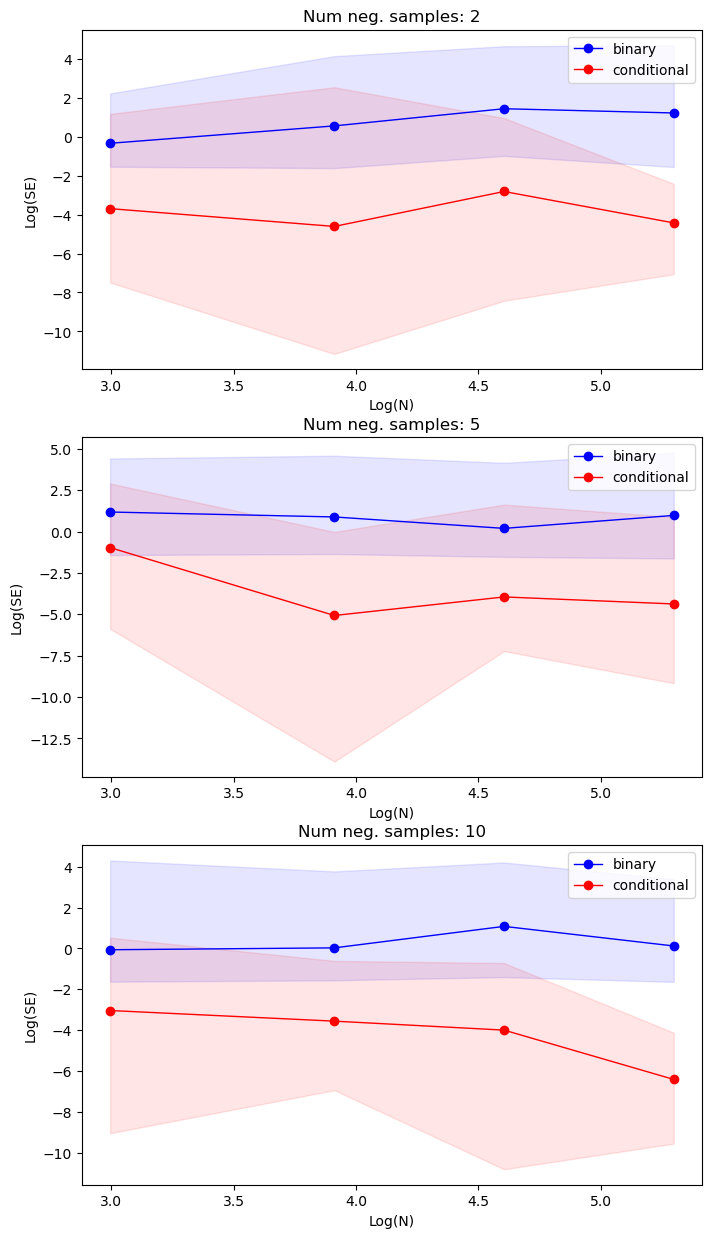

In [28]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()